In [1]:
import os
import pandas as pd
import numpy as np

from scipy.stats import rankdata

import warnings

from madrigal.utils import BASE_DIR, DATA_DIR

import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DDI_PATH = DATA_DIR + 'polypharmacy_new/DrugBank/'
VIEWS_PATH = DATA_DIR + 'views_features_new/'

['str', 'kg', 'cv']


# Utils

In [3]:
raw_drugbank_df = pd.read_pickle('../raw_drugbank_df.pkl')
print(raw_drugbank_df.columns)

drug_metadata = pd.read_pickle(os.path.join(VIEWS_PATH, "combined_metadata_ddi.pkl"))
drug_metadata["view_str"] = 1
mod_avail_df = drug_metadata[[col for col in drug_metadata.columns if col.startswith("view_")]]

drug_metadata = drug_metadata.merge(
    raw_drugbank_df[["drugbank_id", "drug_type", "description", "indication", "moa", "toxicity", "atc_codes", "targets"]].rename(columns={"indication":"indication_drugbank"}), 
    left_on='node_id', right_on='drugbank_id', how='left'
).drop(columns=[
    col for col in drug_metadata.columns 
    if col.endswith("_sig_id") or col.endswith("_pert_dose") or col.startswith("view_tx_") or col.endswith("_sig_id") or (col in {"inchi_key", "drugbank_id", "cv_dose"})
])

# use primekg to get real indications of disease
primekg = pd.read_csv(BASE_DIR + 'raw_data/PrimeKG/kg.csv')
assert primekg[["x_index", "y_index"]].drop_duplicates().shape[0] == pd.concat([
    primekg[["x_index", "y_index"]],
    primekg[["x_index", "y_index"]].rename(columns={"x_index":"y_index", "y_index":"x_index"}),
], axis=1).drop_duplicates().shape[0]  # ensure it's bidirectional

# confirm that "best" drug pairs don't have adverse ddi effects with another dataset
db_polypharmacy = pd.read_csv(DDI_PATH + 'drugbank_ddi_directed_final.tsv', index_col=None)[["label_indexed", "drug_index_1", "drug_index_2"]]
db_polypharmacy = pd.concat([
    db_polypharmacy,
    db_polypharmacy.rename(columns={"drug_index_1":"drug_index_2", "drug_index_2":"drug_index_1"})
], axis=0).drop_duplicates()

# FDA approved drugs from Drugbank site
approved_drugs = pd.read_csv('../approved_drug_link.csv')
organs_csv = pd.read_csv('../drugbank_ddi_organs.csv', sep='\t')
organ_class_mapping = organs_csv.set_index("ddi_class").to_dict()["organ"]  # ddi_class : organ

organ_lst = []
for organs in organ_class_mapping.values():
    organ_lst.extend(organs.split(", "))
organ_counts = Counter(organ_lst)

Index(['drugbank_id', 'drug_name', 'drug_type', 'smiles', 'inchikey',
       'description', 'indication', 'pharmacodynamics', 'moa', 'absorption',
       'metabolism', 'toxicity', 'atc_codes', 'classifications', 'targets',
       'enzymes', 'carriers', 'transporters'],
      dtype='object')


/tmp/ipykernel_2366058/3817781877.py:18: DtypeWarning: Columns (3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  primekg = pd.read_csv(BASE_DIR + 'PrimeKG/kg.csv')


In [4]:
ddi_classes = pd.read_pickle(DDI_PATH + "drugbank_ddi_directed_final_label_map.pkl")
all_labels = list(range(len(ddi_classes)))

to_delete = [
    10, 
    38, 
    65, 
    72,
    83,
    99, 
    147
]
to_delete_classes = [
    "adverse effects, decrease", 
    "cardiotoxicity, decrease",
    "hypertension, decrease",
    "hypoglycemia, decrease",
    "hypotension, decrease",
    "nephrotoxicity, decrease",
    "therapeutic efficacy, increase",
]
valid_ddi_class_indices = np.array([elem for elem in all_labels if elem not in to_delete])
normalized_rank_drugbank = np.load(BASE_DIR + "model_output/DrugBank/split_by_pairs/full_full_all_ddi_DrugBank_nash_drugs_normalized_ranks_700_5_runs_gmean_renormalized.npy", mmap_mode="r")

In [5]:
organs_of_interest = [
    "blood", 
    "heart", 
    "kidney", 
    "gastrointestinal", 
    "liver", 
    "endocrine", 
]

custom_palette = {
    "others/general": "grey", 
    "blood": "orange",  # lightpink
    "heart": "red",  # marron
    "kidney": "purple",  # darkmagenta
    "gastrointestinal": "green",  # mediumseagreen
    "liver": "blue",  # cornflowerblue, steelblue
    "endocrine": "darkkhaki",
}

drug_ind_to_name = drug_metadata["node_name"].dropna().to_dict()
drug_name_to_ind = {name.lower():ind for ind, name in drug_ind_to_name.items()}
drug_id_to_name = drug_metadata[["node_id", "node_name"]].dropna().set_index("node_id").to_dict()["node_name"]
drug_name_to_id = {name.lower():drug_id for drug_id, name in drug_id_to_name.items()}
drug_id_to_ind = drug_metadata["node_id"].dropna().reset_index().set_index("node_id").to_dict()["index"]
primekg_indication = primekg[primekg["relation"] == "indication"]

In [6]:
def get_parpi_cancer_drug_ddi_scores(parpi_df, cancer_name, cancer_drugs):
    '''
    parpi_df: Dataframe of parpi drugs (8 in our case)
    cancer_name: name of cancer (e.g. "ovarian", "pan")
    cancer_drugs: drugs of the cancer of curiosity
    
    returns: 
    cancer_parpi_df - dataframe with the first column being pair of parpi and cancer drug, and
    following columns being ddi scores for each class
    drug_mapping: dictionary mapping cancer drug/parpi name (key) to their DB numbers (value)
    '''
    cancer_parpi_df = defaultdict(list)

    for parpi_id, parpi_name in parpi_df.itertuples(index=False):
        index_1 = drug_id_to_ind[parpi_id]
        for cancer_drug in cancer_drugs:
            if cancer_drug in parpi_df["node_id"].values:  # we are not interested in two PARPi's combinations
                print("PARPi found in pan-cancer drug")
                raise Exception
            index_2 = drug_id_to_ind[cancer_drug]
            ddi = normalized_rank_drugbank[:, index_1, index_2]
            cancer_drug_name = drug_id_to_name[cancer_drug]

            cancer_parpi_df[f"(parpi; {cancer_name} cancer drug)"].append(str(parpi_name).lower() + '; ' + str(cancer_drug_name).lower())
            cancer_parpi_df["DDI"].append(ddi)

    cancer_parpi_df = pd.DataFrame(cancer_parpi_df)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cancer_parpi_df[ddi_classes] = cancer_parpi_df["DDI"].apply(pd.Series)
    cancer_parpi_df_filtered = cancer_parpi_df.drop(columns = to_delete_classes + ["DDI"]).set_index(f"(parpi; {cancer_name} cancer drug)")
    
    return cancer_parpi_df, cancer_parpi_df_filtered

def add_organs_column(highest_long, lowest_long, organ_class_mapping, organs_of_interest, organ_counts, sample_name_col_name="(Disease 1; Disease 2; Drug 1; Drug 2)", num_least_organ=5):
    """
    Add a column indicating the DDI classes's organs to the DDI profile dataframes in place.
    Args:
        highest_long, lowest_long: Long format of DDI profiles
    """
    organs_list = []

    for _, row in highest_long.iterrows():
        ddi_class_name = str(row["ddi_class"])
        organs = list(set([organ if organ in organs_of_interest else "others/general" for organ in organ_class_mapping[ddi_class_name].split(", ")]))
        organs_list.append(organs)

    highest_long["organ"] = organs_list
    highest_long_exploded = highest_long.explode("organ").reset_index(drop=True)
    for key in organ_counts.keys():
        # check if there are any organs with < num_least_organ points
        if organ_counts[key] < num_least_organ:
            highest_long_exploded["organ"] = highest_long_exploded["organ"].replace(key, "others/general")
    
    if lowest_long is not None:
        assert (highest_long["ddi_class"] != lowest_long["ddi_class"]).sum() == 0
        lowest_long["organ"] = organs_list
        lowest_long_exploded = lowest_long.explode("organ").reset_index(drop=True)
        for key in organ_counts.keys():
            # check if there are any organs with < num_least_organ points
            if organ_counts[key] < num_least_organ:
                lowest_long_exploded["organ"] = lowest_long_exploded["organ"].replace(key, "others/general")
    else:
        lowest_long_exploded = None
            
    return highest_long_exploded, lowest_long_exploded

# Data preparation

## PARPi

In [7]:
parpi_df = pd.DataFrame.from_dict({
    "node_id": ["DB09074", "DB11760", "DB12332"],
    "node_name": ["Olaparib", "Talazoparib", "Rucaparib"]
})
parpi = parpi_df["node_id"].values
parpi_names = parpi_df["node_name"].values

for drug_name in parpi_df["node_name"]:
    drug_ind = drug_name_to_ind[drug_name.lower()]
    temp = organs_csv.iloc[db_polypharmacy[(db_polypharmacy['drug_index_1'] == drug_ind)]["label_indexed"]]
    temp["count"] = 1
    print(f"{drug_name}:", temp.shape[0])
    display(temp.groupby(by=["ddi_class", "organ"]).agg(sum).reset_index().query("count >= 5"))

Olaparib: 777


/tmp/ipykernel_2366058/3321296268.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["count"] = 1


ddi_class           organ  count
0                adverse effects, increase  others/general    111
1                       bleeding, increase           blood     66
3                     metabolism, decrease           liver    380
4                     metabolism, increase           liver    138
5              methemoglobinemia, increase           blood     32
7  neutropenia, thrombocytopenia, increase           blood     12
8                    serum level, decrease  others/general      9
9                    serum level, increase  others/general     22

Talazoparib: 310


/tmp/ipykernel_2366058/3321296268.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["count"] = 1


ddi_class           organ  count
0  excretion rate, decrease | serum level, increase   liver, kidney     61
3                       methemoglobinemia, increase           blood     32
4                             serum level, decrease  others/general     10
5                             serum level, increase  others/general    203

Rucaparib: 903


/tmp/ipykernel_2366058/3321296268.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["count"] = 1


ddi_class           organ  count
1  excretion rate, decrease | serum level, increase   liver, kidney    102
4                              metabolism, decrease           liver    638
5                              metabolism, increase           liver     83
6                       methemoglobinemia, increase           blood     27
7                             serum level, decrease  others/general      8
8                             serum level, increase  others/general     42

## Pan-cancer drugs

In [8]:
cancer_terms_pattern = (
    r'\b(?:'
    r'cancer|oncology|'
    r'(?!tumor necrosis factor\b)tumor|'
    r'neoplasm|carcinoma|malignancy|metastasis|metastatic|'
    r'sarcoma|lymphoma|leukemia|myeloma|melanoma|cytoma|teratoma|blastoma|adenoma|glioma'
    r')\b'
)

test_data = pd.Series([
    "This text mentions tumor necrosis factor.",
    "This text mentions tumor necrosis factor and tumor.",
    "This text mentions tumor necrosis factor and cancer.",
    "Another text mentions oncology and tumor.",
    "Yet another text mentions metastatic melanoma and sarcoma.",
    "about cancer, it is known"
])

# Apply the filter using str.contains with the pattern
filtered_data = test_data[test_data.str.contains(cancer_terms_pattern, case=False, regex=True)]
print(filtered_data)

1    This text mentions tumor necrosis factor and t...
2    This text mentions tumor necrosis factor and c...
3            Another text mentions oncology and tumor.
4    Yet another text mentions metastatic melanoma ...
5                            about cancer, it is known
dtype: object


First, use curated database

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7991999/

In [9]:
all_drugbank_ids = drug_metadata['node_id'].dropna().values.tolist()
cancerdrugs_db = pd.read_table("./cancerdrugsdb.txt")
cancerdrugs_db["DrugBank ID"] = cancerdrugs_db["DrugBank ID"].str.findall(".*>(DB\d{5})<.*")
assert (cancerdrugs_db["DrugBank ID"].apply(len) > 1).sum() == 0
cancerdrugs_db = (
    cancerdrugs_db.explode("DrugBank ID").dropna(subset=["DrugBank ID"]).
    query("`DrugBank ID` in @all_drugbank_ids").
    drop(columns=["Generic", "ChEMBL", "Targets", "Last Update", "Unnamed: 14"])
)
display(cancerdrugs_db[(cancerdrugs_db["EMA"] != "Y") & (cancerdrugs_db["FDA"] != "Y") & (cancerdrugs_db["EN"] != "Y")])

all_parpi_ids = drug_metadata[drug_metadata["cv_moa"]=="PARP inhibitor"][["node_id", "node_name"]]
all_parpi_ids = pd.concat([
    all_parpi_ids, 
    drug_metadata[drug_metadata["node_name"].isin({"Pamiparib", "Fluzoparib"})][["node_name", "node_id"]]
]).reset_index(drop=True)
all_parpis_ids = all_parpi_ids["node_id"].values
pan_cancer_drugs = list(set(cancerdrugs_db["DrugBank ID"].drop_duplicates().values) - set(all_parpis_ids))
print(len(pan_cancer_drugs))

Product EMA FDA EN        Other WHO    Year DrugBank ID   
3        Aclarubicin   N   N  N        Japan   N     NaN     DB11617  \
15         Amrubicin   N   N  N        Japan   N  2002.0     DB06263   
16         Amsacrine   N   N  N          NaN   N  1987.0     DB00276   
31         Belotecan   N   N  N  South Korea   N  2003.0     DB12459   
55          Carmofur   N   N  N        Japan   N     NaN     DB09010   
220      Pirarubicin   N   N  N        Japan   N     NaN     DB11616   
238      Ranimustine   N   N  N        Japan   N     NaN     DB13832   
271  Tegafur, Uracil   N   N  N        Japan   N     NaN     DB09256   

                  ATC                           Indications  
3             L01DB04                                   NaN  
15            L01DB10                                   NaN  
16            L01XX01  Leukemia, Acute; Refractory Leukemia  
31            L01CE04                                   NaN  
55            L01BC04                                   NaN  
220           L01DB08                                   NaN  
238           L01AD07                                   NaN  
271  L01BC03; L01BC53               Advanced Gastric Cancer

215


Then, supplement with DrugCentral (thru PrimeKG)

In [10]:
pan_cancer_indications = primekg_indication[
    primekg_indication["x_name"].str.contains(cancer_terms_pattern, case=False) & \
    (primekg_indication["x_type"] == "disease") & \
    (primekg_indication["y_type"] == "drug")
]
print(pan_cancer_indications["x_name"].unique())

# remove any drugs that don't appear in metadata OR any drugs that are not fda approved
# print(set(pan_cancer_indications["y_id"].unique()) & set(drug_metadata["node_id"].dropna().values) - set(pan_cancer_drugs))
print(set(pan_cancer_indications["y_id"].unique()) & set(drug_metadata["node_id"].dropna().values) - set(approved_drugs["DrugBank ID"].values) - set(pan_cancer_drugs))
pan_cancer_drugs += list(
    (
        set(pan_cancer_indications["y_id"].unique()) & set(drug_metadata["node_id"].dropna().values) & \
        set(approved_drugs["DrugBank ID"].values)
    ) - set(parpi_df["node_id"].values) - set(pan_cancer_drugs) - set(all_parpis_ids)
)
print(len(pan_cancer_drugs))

['superficial multifocal basal cell carcinoma'
 'humoral hypercalcemia of malignancy'
 'acute lymphoblastic leukemia (disease)'
 'leukemia, lymphocytic, susceptibility to'
 'acute lymphoblastic/lymphocytic leukemia'
 'precursor T-cell acute lymphoblastic leukemia'
 'primary cutaneous T-cell lymphoma' 'Hodgkins lymphoma'
 'classic Hodgkin lymphoma'
 'classic Hodgkin lymphoma, lymphocyte-rich type' 'non-Hodgkin lymphoma'
 'lymphoma' 'mantle cell lymphoma' 'lymphoma, non-Hodgkin, familial'
 'B-cell neoplasm' 'hairy cell leukemia' 'hairy cell leukemia variant'
 'melanoma' 'follicular lymphoma' 'neoplasm of mature B-cells'
 "Kaposi's sarcoma (disease)" 'female breast carcinoma' 'ovarian cancer'
 'hereditary breast ovarian cancer syndrome'
 'ovarian small cell carcinoma' 'yolk sac tumor'
 'borderline epithelial tumor of ovary'
 'malignant non-dysgerminomatous germ cell tumor of ovary'
 'familial ovarian cancer'
 'hereditary site-specific ovarian cancer syndrome'
 'malignant germ cell tumor o

Can potentially add back:
- DB06266: Lonidamine, discontinued due to [logistics issues](https://drugs.ncats.io/substance/U78804BIDR)
- DB13164: Olmutinib, approved in KR AND breakthrough therapy-designated by FDA in 2015
- DB06185: Forodesine, approved in JP
- DB11737: Icotinib, approved in CN
- DB11812: Talaporfin, approved in JP
- DB12323: Radotinib, approved in KR
- DB04942: Tamibarotene, approved in JP AND fast tracked-designated by FDA in 2023

Keep removed:
- DB14031: Tretamine, one of the oldest chemos, now withdrawn and succeeded
- DB06255: Incadronic Acid, approved/discontinued for other diseases
- DB11620: Neridronic Acid, approved/discontinued for other diseases
- DB05168: Vintafolide, discontinued due to low efficacy

In [11]:
primekg_drugs_not_approved_interesting = ["DB06266", "DB12323", "DB11812", "DB06185", "DB04942", "DB11737", "DB13164"]
pan_cancer_drugs += primekg_drugs_not_approved_interesting

Finally, supplement with ATC==L01

In [12]:
drugs_atc_l01 = drug_metadata[
    (~drug_metadata["atc_codes"].isna()) & \
    (drug_metadata["atc_codes"].apply(
        lambda lst: sum([atc.startswith("L01") for atc in lst] if lst == lst else [0])) > 0
    ) & \
    (~drug_metadata["node_id"].isna()) & \
    (~drug_metadata["node_id"].isin(all_parpis_ids))
][["node_id", "node_name"]]
len(drugs_atc_l01)

202

In [13]:
print(set(drugs_atc_l01["node_id"].values) - set(pan_cancer_drugs))

{'DB04977', 'DB04849', 'DB13318', 'DB13243', 'DB12967', 'DB04996', 'DB13677', 'DB00261', 'DB11841', 'DB05168', 'DB13334', 'DB00179', 'DB13543', 'DB11618', 'DB00992', 'DB11697', 'DB12832', 'DB06233', 'DB13339', 'DB11678', 'DB11689', 'DB13069', 'DB08486', 'DB11999', 'DB11526', 'DB00648', 'DB13304', 'DB11907', 'DB11717', 'DB00482'}


Remove:
- DB04996: Satraplatin, discontinued
- DB11907: Rociletinib, discontinued
- DB13318: Demecolcine, no info
- DB14769: Pamiparib, PARPi
- DB06233: Ridaforolimus, discontinued
- DB13334: Mannosulfan, no info
- DB11618: Zorubicin, no info
- DB00261: Anagrelide, treat thrombocythemia secondary to malignancies
- DB00179: Masoprocol, actinic keratoses
- DB13243: Tiazofurine, discontinued
- DB13304: Triaziquone, no info
- DB00992: Methyl aminolevulinate, actinic keratosis
- DB08486: Efaproxiral, discontinued
- DB11526: Mastinib, vet drug
- DB12967: Mitoguazone, discontinued
- DB13543: Mitobronitol, no info
- DB13339: Etoglucid, no info

In [14]:
drugs_atc_l020304 = drug_metadata[
    (~drug_metadata["atc_codes"].isna()) & \
    (drug_metadata["atc_codes"].apply(
        lambda lst: sum([atc.startswith("L02") or atc.startswith("L03") or atc.startswith("L04") for atc in lst] if lst == lst else [0])) > 0  # must be L
    ) & \
    (
        (drug_metadata["description"].str.contains(cancer_terms_pattern, case=False)) | \
        (drug_metadata["disease.area"].str.contains(cancer_terms_pattern, case=False)) | \
        (drug_metadata["indication"].str.contains(cancer_terms_pattern, case=False)) | \
        (drug_metadata["indication_drugbank"].str.contains(cancer_terms_pattern, case=False)) | \
        (drug_metadata["moa"].str.contains(cancer_terms_pattern, case=False))  # one field must contain cancer-related mentioning
    ) & \
    (~drug_metadata["node_id"].isna()) & \
    (~drug_metadata["node_id"].isin(all_parpis_ids))  # & drug_metadata["node_id"].isin(approved_drugs["DrugBank ID"].values)  # must be approved
][["node_id", "node_name"]]

In [15]:
print(set(drugs_atc_l020304["node_id"].values) - set(pan_cancer_drugs))

{'DB11366', 'DB12154', 'DB11996', 'DB00357', 'DB01097', 'DB00106'}


Remove: 
- DB00106: Abarelix, withdrawn
- DB01097: Leflunomide, unrelated
- DB11366: Roquinimex, discontinued
- DB11996: Thymopentin, unclear status

In [16]:
atc_l_drugs_interesting = [
    "DB12154", "DB00357", 
    "DB04977", "DB12832", "DB11841", "DB11717", "DB11678", "DB11697", "DB13069",
    "DB00648", "DB11689", "DB05168", "DB00482", "DB04849", "DB11999", "DB13677", 
]
pan_cancer_drugs += atc_l_drugs_interesting
pan_cancer_drugs += [drug_name_to_id["ceralasertib"]]  # add investigatory drugs that would be used in analyses, mk-1775
pan_cancer_drugs = list(set(pan_cancer_drugs) - set(all_parpis_ids))
print(len(pan_cancer_drugs))

287


In [17]:
all_other_drugs_list = list(
    set(drug_metadata['node_id'].dropna().values) & set(approved_drugs["DrugBank ID"].values) - \
    set(all_parpis_ids) - set(pan_cancer_drugs)
)  # remove parpis and ensure the drug has been approved
print(len(all_other_drugs_list))

2340


In [18]:
pan_cancer_parpi_df, pan_cancer_parpi_df_filtered = get_parpi_cancer_drug_ddi_scores(parpi_df, "pan", pan_cancer_drugs)

all_pan_cancer_long = pd.melt(
    pan_cancer_parpi_df_filtered.reset_index(), 
    id_vars=pan_cancer_parpi_df_filtered.index.name, 
    value_vars=pan_cancer_parpi_df_filtered.columns, 
    var_name="ddi_class"
)

test_long = all_pan_cancer_long.copy()
test_long[["parpi", "cancer drug"]] = test_long["(parpi; pan cancer drug)"].str.split("; ", expand=True)
test_long["cancer drug id"] = test_long["cancer drug"].apply(lambda x: drug_name_to_id[x])
test_long = test_long.drop(columns=["(parpi; pan cancer drug)"])[["parpi", "cancer drug", "cancer drug id", "ddi_class", "value"]]

all_pan_cancer_long_exploded, _ = add_organs_column(
    all_pan_cancer_long, None, 
    organ_class_mapping, organs_of_interest, organ_counts, 
    sample_name_col_name="(parpi; pan cancer drug)", num_least_organ=5
)

# list of organs that can be indexed into, corresponding to the 140 ddi classes (filtered)
organ_list = all_pan_cancer_long[all_pan_cancer_long["(parpi; pan cancer drug)"] == "olaparib; paclitaxel"]["organ"].values

# maps each of the 140 (adverse) ddi classes of interest to a SPECIFIC organ
specific_organs_mapping = defaultdict(list)
for i, organs in enumerate(organ_list):
    for organ in organs:
        specific_organs_mapping[organ].append(i)

# PARPi Analyses

## Clinically-investigated(/ing) pairs

1. Olaparib + paclitaxel (neutropenia risk from GOLD): The only ground truth is "Olaparib, The metabolism of Olaparib can be increased when combined with Paclitaxel.", and so capturing this is non-trivial
2. Olaparib + abiraterone, good (approved)
3. Olaparib + ceralasertib (AZD6738), unsure

In [19]:
drug_1_name = "olaparib"
drug_2_name = "paclitaxel"
drug_1_ind = drug_name_to_ind[drug_1_name]
drug_2_ind = drug_name_to_ind[drug_2_name]
ddi_adverse_labels = db_polypharmacy[(db_polypharmacy['drug_index_1'] == drug_1_ind) & (db_polypharmacy['drug_index_2'] == drug_2_ind)]['label_indexed'].values
if ddi_adverse_labels.shape[0] != 0:
    print(f"{drug_1_name}, {drug_2_name}:", ddi_classes[ddi_adverse_labels].values[0])
else:
    print(f"{drug_1_name}, {drug_2_name}:", "No ground truth.")

olaparib, paclitaxel: metabolism, increase


In [26]:
drug_1_name = "olaparib"
drug_2_name = "abiraterone"
drug_1_ind = drug_name_to_ind[drug_1_name]
drug_2_ind = drug_name_to_ind[drug_2_name]
ddi_adverse_labels = db_polypharmacy[(db_polypharmacy['drug_index_1'] == drug_1_ind) & (db_polypharmacy['drug_index_2'] == drug_2_ind)]['label_indexed'].values
if ddi_adverse_labels.shape[0] != 0:
    print(f"{drug_1_name}, {drug_2_name}:", ddi_classes[ddi_adverse_labels].values[0])
else:
    print(f"{drug_1_name}, {drug_2_name}:", "No ground truth.")

olaparib, abiraterone: No ground truth.


In [27]:
drug_1_name = "olaparib"
drug_2_name = "ceralasertib"
drug_1_ind = drug_name_to_ind[drug_1_name]
drug_2_ind = drug_name_to_ind[drug_2_name]
ddi_adverse_labels = db_polypharmacy[(db_polypharmacy['drug_index_1'] == drug_1_ind) & (db_polypharmacy['drug_index_2'] == drug_2_ind)]['label_indexed'].values
if ddi_adverse_labels.shape[0] != 0:
    print(f"{drug_1_name}, {drug_2_name}:", ddi_classes[ddi_adverse_labels].values[0])
else:
    print(f"{drug_1_name}, {drug_2_name}:", "No ground truth.")

olaparib, ceralasertib: No ground truth.


435.602787456446 416.0 218.5 672.5
816.0 93.90%
363.0 42.68%
687.0 76.48%


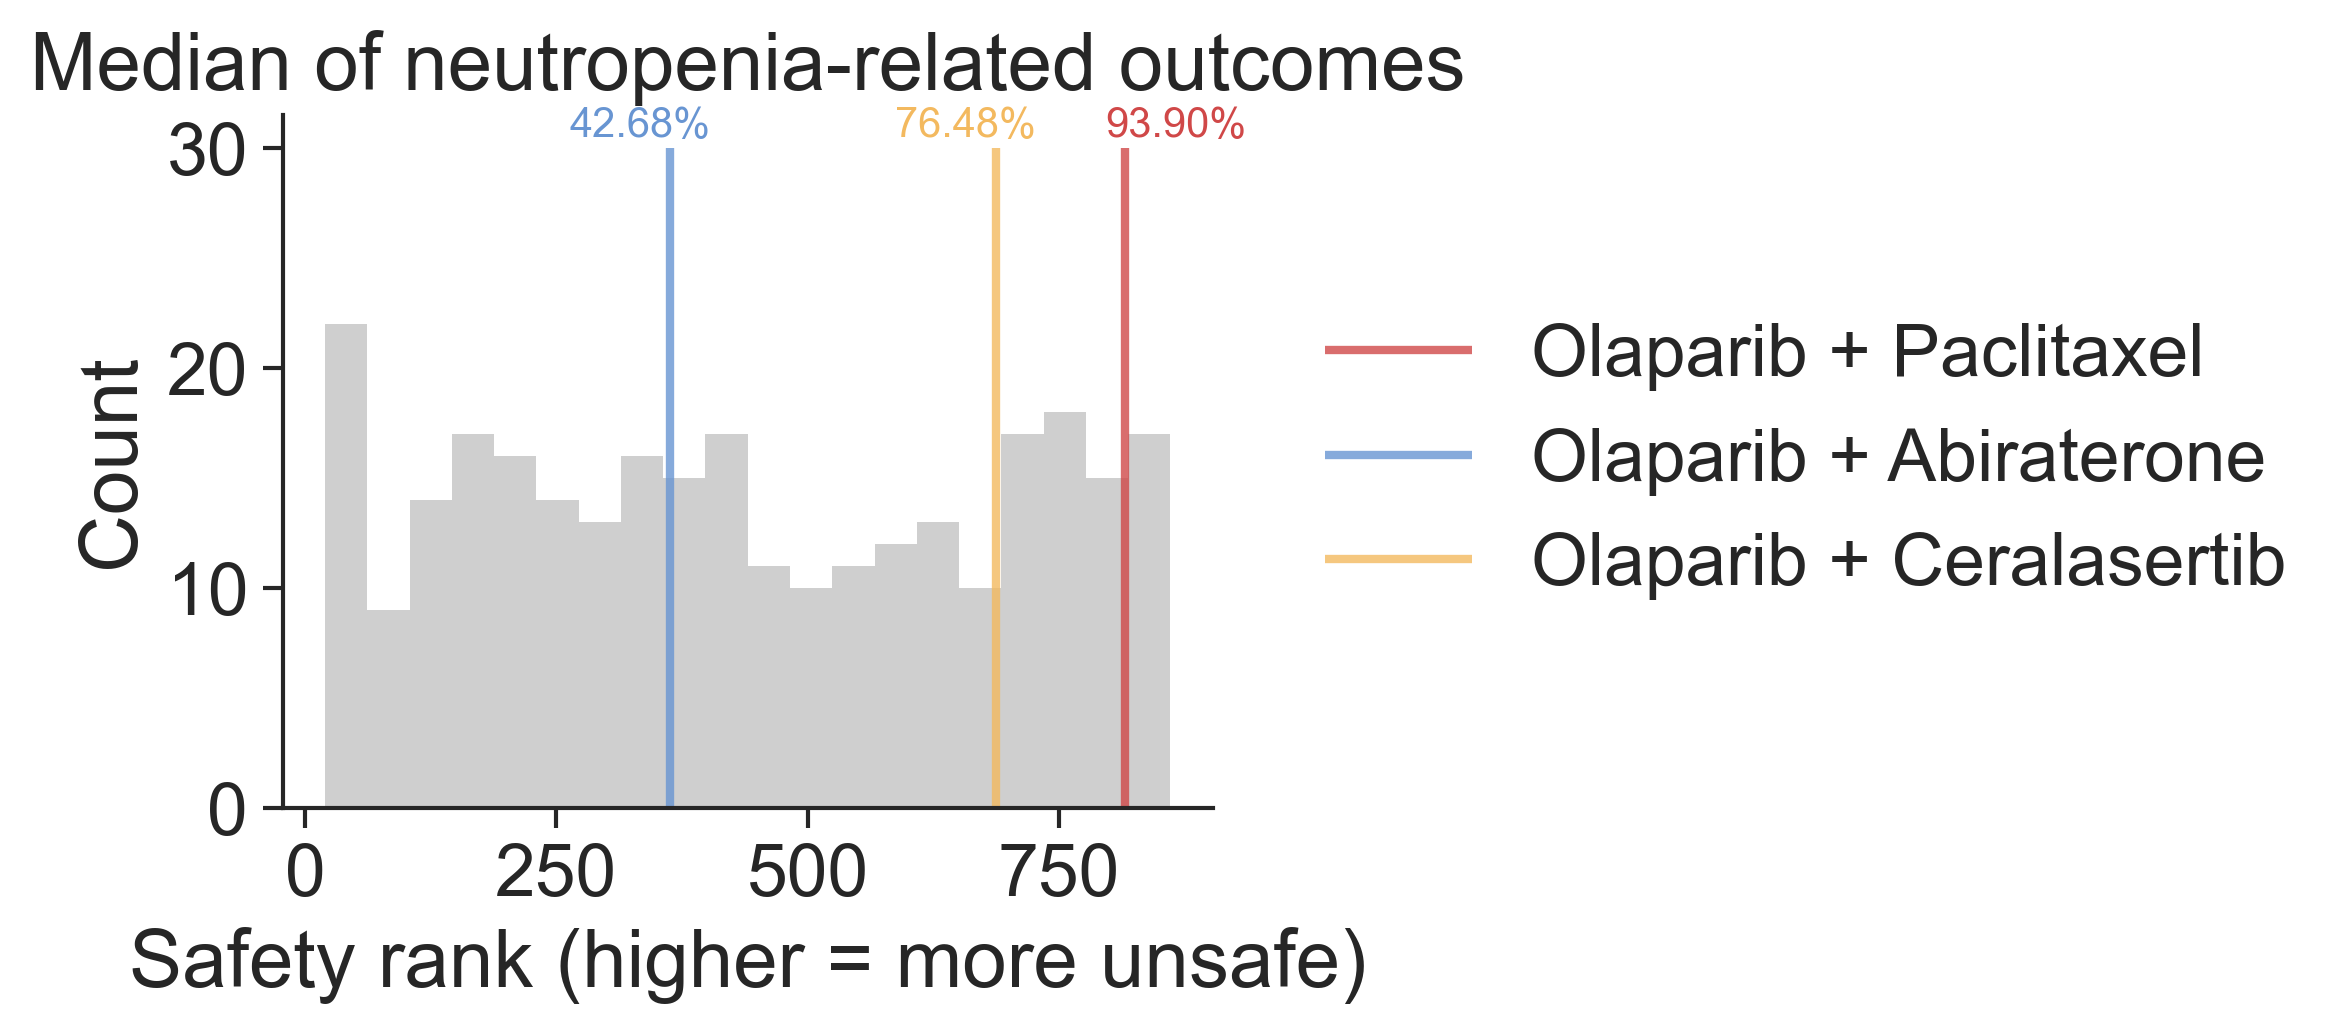

In [ ]:
parpi_cancer_drug_scores = pan_cancer_parpi_df_filtered[[col for col in pan_cancer_parpi_df_filtered.columns if col in {
    "cytopenia, increase", "myelosuppression, anemia, severe leukopenia, increase", "neutropenia, increase", "neutropenia, thrombocytopenia, increase"
}]].mean(axis=1)
# parpi_cancer_drug_scores = pan_cancer_parpi_df_filtered[[col for col in pan_cancer_parpi_df_filtered.columns if col in {
#     "cytopenia, increase", "myelosuppression, anemia, severe leukopenia, increase", "neutropenia, increase", "neutropenia, thrombocytopenia, increase"
# }]].median(axis=1)
# parpi_cancer_drug_scores = pan_cancer_parpi_df_filtered[[col for col in pan_cancer_parpi_df_filtered.columns if "blood" in organ_class_mapping[col]]].median(axis=1)
# parpi_cancer_drug_scores = pan_cancer_parpi_df_filtered[[col for col in pan_cancer_parpi_df_filtered.columns if "blood" in organ_class_mapping[col]]].mean(axis=1)
# parpi_cancer_drug_scores = pan_cancer_parpi_df_filtered[[col for col in pan_cancer_parpi_df_filtered.columns if "blood" in organ_class_mapping[col]]].apply(lambda row: np.mean(np.partition(row, len(row)-5)[-5:]), axis=1)
# parpi_cancer_drug_scores = pan_cancer_parpi_df_filtered[[col for col in pan_cancer_parpi_df_filtered.columns if "blood" in organ_class_mapping[col]]].apply(lambda row: np.mean(np.partition(row, len(row)-10)[-10:]), axis=1)

parpi_cancer_drug_pairs = parpi_cancer_drug_scores.index.values
parpi_cancer_ranks = rankdata(parpi_cancer_drug_scores.values, method="average")

olaparib_any_ranks = [rank for drug_pair, rank in zip(parpi_cancer_drug_pairs, parpi_cancer_ranks) if drug_pair.split("; ")[0] == "olaparib"]
print(
    np.mean(olaparib_any_ranks), 
    np.median(olaparib_any_ranks), 
    np.quantile(olaparib_any_ranks, 0.25), 
    np.quantile(olaparib_any_ranks, 0.75)
)

olaparib_paclitaxel_rank = [rank for drug_pair, rank in zip(parpi_cancer_drug_pairs, parpi_cancer_ranks) if drug_pair == "olaparib; paclitaxel"][0]
olaparib_abiraterone_rank = [rank for drug_pair, rank in zip(parpi_cancer_drug_pairs, parpi_cancer_ranks) if drug_pair == "olaparib; abiraterone"][0]
olaparib_ceralasertib_rank = [rank for drug_pair, rank in zip(parpi_cancer_drug_pairs, parpi_cancer_ranks) if drug_pair == "olaparib; ceralasertib"][0]
olaparib_paclitaxel_rank_percentile = (
    (np.array(olaparib_any_ranks) < olaparib_paclitaxel_rank).mean() + \
    (np.array(olaparib_any_ranks) <= olaparib_paclitaxel_rank).mean()
) / 2 * 100
olaparib_abiraterone_rank_percentile = (
    (np.array(olaparib_any_ranks) < olaparib_abiraterone_rank).mean() +\
    (np.array(olaparib_any_ranks) <= olaparib_abiraterone_rank).mean()
) / 2 * 100
olaparib_ceralasertib_rank_percentile = (
    (np.array(olaparib_any_ranks) < olaparib_ceralasertib_rank).mean() +\
    (np.array(olaparib_any_ranks) <= olaparib_ceralasertib_rank).mean()
) / 2 * 100
print(olaparib_paclitaxel_rank, f"{olaparib_paclitaxel_rank_percentile:.2f}%")
print(olaparib_abiraterone_rank, f"{olaparib_abiraterone_rank_percentile:.2f}%")
print(olaparib_ceralasertib_rank, f"{olaparib_ceralasertib_rank_percentile:.2f}%")

from matplotlib import font_manager as fm
arial_path = "../arial.ttf"
fm.fontManager.addfont(arial_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(4, 3), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
sns.histplot(data=pd.DataFrame(olaparib_any_ranks, columns=["data"]), x="data", bins=20, stat="count", color="silver", element="step", lw=0)
sns.despine()

ymax = 30
plt.vlines(x=olaparib_paclitaxel_rank, ymin=0, ymax=ymax, color="#D04848", label="Olaparib + Paclitaxel", alpha=.8, lw=2)
plt.vlines(x=olaparib_abiraterone_rank, ymin=0, ymax=ymax, color="#6895D2", label="Olaparib + Abiraterone", alpha=.8, lw=2)
plt.vlines(x=olaparib_ceralasertib_rank, ymin=0, ymax=ymax, color="#F3B95F", label="Olaparib + Ceralasertib", alpha=.8, lw=2)
plt.text(olaparib_paclitaxel_rank-20, ymax+0.5, f"{olaparib_paclitaxel_rank_percentile:.2f}%", fontsize=10, color="#D04848")
plt.text(olaparib_abiraterone_rank-100, ymax+0.5, f"{olaparib_abiraterone_rank_percentile:.2f}%", fontsize=10, color="#6895D2")
plt.text(olaparib_ceralasertib_rank-100, ymax+0.5, f"{olaparib_ceralasertib_rank_percentile:.2f}%", fontsize=10, color="#F3B95F")

plt.xlabel("Safety rank (higher = more unsafe)")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.title("Median of neutropenia-related outcomes")
# plt.title("Mean of neutropenia-related outcomes")
# plt.title("Median of hematological outcomes")
# plt.title("Mean of hematological outcomes")
# plt.title("Highest 5 mean of all outcomes")
# plt.title("Highest 10 mean of all outcomes")

# plt.savefig("./figs/fig4_known_olaparib_combos_histogram_neutropenia_median.svg", format="svg", dpi=300)
plt.show()

## Comparing different groups of drug combinations

In [20]:
groups_organ_results = dict() # medians to display for each bar

### Clinically-investigating PARPi-cancer drug combinations

In [21]:
studied_parpi_combos = {
    'olaparib':['bevacizumab', 'temozolomide', 'cediranib', 'ramucirumab', 'alpelisib', 'capivasertib', 'selumetinib', 'durvalumab', 'ceralasertib', 'prexasertib', 'mk-1775', 'abiraterone'], 
    'veliparib':['paclitaxel', 'carboplatin', 'cisplatin', 'gemcitabine', 'temozolomide', 'irinotecan', 'fluorouracil', 'lapatinib'],
    'rucaparib':['temozolomide', 'sacituzumab'],
    'talazoparib':['ZEN-3694', "enzalutamide"],
    'niraparib':['bevacizumab', 'pembrolizumab', 'ipilimumab', 'nivolumab', 'dostarlimab', 'abiraterone']
}

parpi_drug_pairs_phase = {
    "olaparib; temozolomide": "phase 2",
    "olaparib; cediranib": "phase 3",
    "olaparib; alpelisib": "phase 1",
    "olaparib; capivasertib": "phase 1",
    "olaparib; selumetinib": "phase 1",
    "olaparib; ceralasertib": "phase 2",
    "olaparib; prexasertib": "phase 1",
    "olaparib; mk-1775": "phase 2", 
    "olaparib; abiraterone": "approved",
    "olaparib; paclitaxel": "control",
    
    "veliparib; paclitaxel": "phase 2",
    "veliparib; carboplatin": "phase 3",
    "veliparib; cisplatin": "phase 2",
    "veliparib; gemcitabine": "phase 2",
    "veliparib; temozolomide": "phase 2",
    "veliparib; irinotecan": "phase 2",
    "veliparib; fluorouracil": "phase 2",
    "veliparib; lapatinib": "phase 1",
    "rucaparib; temozolomide": "phase 2",
    
    "talazoparib; enzalutamide": "approved",
    
    "niraparib; abiraterone": "approved",
}

In [22]:
groups_organ_results["PARPi combinations (clinically investigated or approved)"] = dict()

for parpi_name, cancer_drug_list in studied_parpi_combos.items():
    if parpi_name not in parpi_df["node_name"].str.lower().values:
        continue
    for cancer_drug_name in cancer_drug_list:
        if cancer_drug_name in drug_metadata["node_name"].dropna().str.lower().values:
            print(parpi_name, cancer_drug_name)
            parpi_index = drug_name_to_ind[parpi_name]
            cancer_drug_index = drug_name_to_ind[cancer_drug_name]
            ddi_filtered = normalized_rank_drugbank[:, parpi_index, cancer_drug_index][valid_ddi_class_indices]

            # specific_organs_mapping
            groups_organ_results["PARPi combinations (clinically investigated or approved)"][f"{parpi_name}; {cancer_drug_name}"] = dict()
            for organ, organ_ddi_index_lst in specific_organs_mapping.items():
                groups_organ_results["PARPi combinations (clinically investigated or approved)"][f"{parpi_name}; {cancer_drug_name}"][organ] = ddi_filtered[organ_ddi_index_lst]
                

olaparib temozolomide
olaparib cediranib
olaparib alpelisib
olaparib capivasertib
olaparib selumetinib
olaparib ceralasertib
olaparib prexasertib
olaparib mk-1775
olaparib abiraterone
rucaparib temozolomide
talazoparib enzalutamide


### PARPi + cancer drugs

In [23]:
groups_organ_results["PARPi combinations (with any other cancer drug)"] = dict()
for parpi_name in parpi_df["node_name"].values:
    for cancer_drug_id in pan_cancer_drugs:
        cancer_drug_name = drug_id_to_name[cancer_drug_id].lower()
        if cancer_drug_name in drug_metadata["node_name"].dropna().str.lower().values:
            parpi_index = drug_name_to_ind[parpi_name.lower()]
            cancer_drug_index = drug_name_to_ind[cancer_drug_name]
            ddi_filtered = normalized_rank_drugbank[:, parpi_index, cancer_drug_index][valid_ddi_class_indices]

            # specific_organs_mapping
            groups_organ_results["PARPi combinations (with any other cancer drug)"][f"{parpi_name}; {cancer_drug_name}"] = dict()
            for organ, organ_ddi_index_lst in specific_organs_mapping.items():
                groups_organ_results["PARPi combinations (with any other cancer drug)"][f"{parpi_name}; {cancer_drug_name}"][organ] = ddi_filtered[organ_ddi_index_lst]

### Approved drug combinations

In [24]:
all_dbids = set(drug_metadata["node_id"].dropna().values)
all_clinical_combos = pd.read_csv(BASE_DIR + "raw_data/cdcdb/all_combs_unormalized.csv")[["drugbank_identifiers", "source_id", "source"]].dropna(subset=["drugbank_identifiers"])
all_clinical_combos["drugbank_identifiers"] = all_clinical_combos["drugbank_identifiers"].apply(
    lambda lst: ";".join(sorted([
        dbid for dbid in lst.strip("[]\"").split("\", \"") 
        if dbid.startswith("DB") and len(dbid) == 7 and dbid in all_dbids
    ]))
)
all_clinical_combos = all_clinical_combos[all_clinical_combos["drugbank_identifiers"].apply(len) >= 15].drop_duplicates().reset_index(drop=True)  # 15 == 2 drugs
all_clinical_combos["label"] = np.arange(all_clinical_combos.shape[0])
display(all_clinical_combos)
print(all_clinical_combos.drop_duplicates(subset=["drugbank_identifiers"]).shape[0])

drugbank_identifiers    source_id              source  label
0              DB00529;DB01004  NCT00000134  clinicaltrials.gov      0
1              DB00529;DB01004  NCT00000136  clinicaltrials.gov      1
2              DB00260;DB00363  NCT00000372  clinicaltrials.gov      2
3              DB00704;DB01104  NCT00000451  clinicaltrials.gov      3
4      DB00007;DB00396;DB00783  NCT00001322  clinicaltrials.gov      4
...                        ...          ...                 ...    ...
16894          DB00977;DB09389          NaN          orangebook  16894
16895          DB00823;DB00977          NaN          orangebook  16895
16896          DB00304;DB00977          NaN          orangebook  16896
16897          DB00957;DB00977          NaN          orangebook  16897
16898  DB00717;DB00977;DB14491          NaN          orangebook  16898

[16899 rows x 4 columns]

8728


#### Orange book combos (incl. all)

In [25]:
# all_approved_drugs = set(approved_drugs["DrugBank ID"].values)
temp = all_clinical_combos[all_clinical_combos["source"].apply(lambda st: "orangebook" in st)].copy()[["drugbank_identifiers", "label"]]
# temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join([drug for drug in lst.split(";") if drug in all_approved_drugs]))
temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join(lst.split(";")))
temp = temp[temp["drugbank_identifiers"].apply(len) >= 15]
temp["drugbank_identifiers"] = temp["drugbank_identifiers"].str.split(";")
temp = temp.explode("drugbank_identifiers")
temp["value"] = 1
temp = pd.pivot_table(temp, values="value", index="drugbank_identifiers", columns="label").fillna(0).rename_axis(index=None)
temp = pd.DataFrame(temp.values @ temp.values.T > 0, dtype=bool, columns=temp.index, index=temp.index)
temp = pd.melt(temp.reset_index(), id_vars="index")
temp = temp[temp["value"] & (temp["index"] != temp["variable"])].drop(columns=["value"]).rename(columns={"index":"drug_1", "variable":"drug_2"}).reset_index(drop=True)
orange_book_combos_pairs_list = temp.values.tolist()

In [26]:
from time import time
groups_organ_results["FDA-approved drug combinations"] = dict()

start = time()
for i, (drug_1_id, drug_2_id) in enumerate(orange_book_combos_pairs_list):
    drug_1_name = drug_id_to_name[drug_1_id].lower()
    drug_2_name = drug_id_to_name[drug_2_id].lower()
    drug_1_index = drug_name_to_ind[drug_1_name]
    drug_2_index = drug_name_to_ind[drug_2_name]
    ddi_filtered = normalized_rank_drugbank[:, drug_1_index, drug_2_index][valid_ddi_class_indices]
    
    # specific_organs_mapping
    groups_organ_results["FDA-approved drug combinations"][f"{drug_1_name}; {drug_2_name}"] = dict()
    for organ, organ_ddi_index_lst in specific_organs_mapping.items():
        groups_organ_results["FDA-approved drug combinations"][f"{drug_1_name}; {drug_2_name}"][organ] = ddi_filtered[organ_ddi_index_lst]
        
    if i % 1000 == 1:
        print(i)
        
end = time()
print((end-start)/60)

1
1001
2.002257430553436


#### Orange book combos (with and without safety concern subsets) [BACKLOG]

In [ ]:
# orangebook_combos = pd.read_csv(BASE_DIR + "raw_data/cdcdb/orangebook_combs_df.csv")[["drugbank_ids", "TYPE", "Approval_Date", "RLD"]].dropna(subset=["drugbank_ids"])
# orangebook_combos["drugbank_identifiers"] = orangebook_combos["drugbank_ids"].apply(
#     lambda lst: ";".join(sorted([
#         dbid for dbid in lst.strip("[]\"").split("\", \"") 
#         if dbid.startswith("DB") and len(dbid) == 7 and dbid in all_dbids
#     ]))
# )
# orangebook_combos = orangebook_combos[orangebook_combos["drugbank_identifiers"].apply(len) >= 15].drop_duplicates().reset_index(drop=True)  # 15 == 2 drugs
# orangebook_combos["label"] = np.arange(orangebook_combos.shape[0])

# # Get potential safety flags from orangebook
# orangebook_combos["marketing_discontinued"] = orangebook_combos["TYPE"].eq("DISCN")

# now = pd.Timestamp("2025-01-01")
# orangebook_combos["approval_dt"] = pd.to_datetime(
#     orangebook_combos["Approval_Date"].str.replace("Approved Prior to Jan 1, 1982", "Dec 31, 1981"),
#     errors="coerce")
# orangebook_combos["yrs_on_market"] = (now - orangebook_combos["approval_dt"]).dt.days / 365.25
# orangebook_combos["recently_discontinued"] = orangebook_combos["marketing_discontinued"] & (orangebook_combos["yrs_on_market"] < 20)

# orangebook_combos["rld_discontinued"] = orangebook_combos["marketing_discontinued"] & orangebook_combos["RLD"].eq("Yes")

# # 2) roll up to one convenience column
# flag_cols = ["recently_discontinued",
#              "rld_discontinued"]

# orangebook_combos["POSSIBLE_SAFETY_FLAG"] = orangebook_combos[flag_cols].any(axis=1)
# orangebook_combos = orangebook_combos.drop(columns=["drugbank_ids", "TYPE", "Approval_Date", "RLD", "approval_dt", "yrs_on_market"] + flag_cols)
# orangebook_combos_with_safety_concerns = orangebook_combos[orangebook_combos["POSSIBLE_SAFETY_FLAG"]].reset_index(drop=True).drop_duplicates(subset=["drugbank_identifiers"])
# orangebook_combos_without_safety_concerns = orangebook_combos[~orangebook_combos["POSSIBLE_SAFETY_FLAG"]].reset_index(drop=True).drop_duplicates(subset=["drugbank_identifiers"])

##### With safety concerns

In [ ]:
# temp = orangebook_combos_with_safety_concerns[["drugbank_identifiers", "label"]]
# # temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join([drug for drug in lst.split(";") if drug in all_approved_drugs]))
# temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join(lst.split(";")))
# temp = temp[temp["drugbank_identifiers"].apply(len) >= 15]
# temp["drugbank_identifiers"] = temp["drugbank_identifiers"].str.split(";")
# temp = temp.explode("drugbank_identifiers")
# temp["value"] = 1
# temp = pd.pivot_table(temp, values="value", index="drugbank_identifiers", columns="label").fillna(0).rename_axis(index=None)
# temp = pd.DataFrame(temp.values @ temp.values.T > 0, dtype=bool, columns=temp.index, index=temp.index)
# temp = pd.melt(temp.reset_index(), id_vars="index")
# temp = temp[temp["value"] & (temp["index"] != temp["variable"])].drop(columns=["value"]).rename(columns={"index":"drug_1", "variable":"drug_2"}).reset_index(drop=True)
# orange_book_combos_pairs_list = temp.values.tolist()

/tmp/ipykernel_1565900/574136097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join(lst.split(";")))


In [ ]:
# from time import time
# groups_organ_results["orange book drug pairs (incl. all, with safety concern)"] = dict()

# start = time()
# for i, (drug_1_id, drug_2_id) in enumerate(orange_book_combos_pairs_list):
#     drug_1_name = drug_id_to_name[drug_1_id].lower()
#     drug_2_name = drug_id_to_name[drug_2_id].lower()
#     drug_1_index = drug_name_to_ind[drug_1_name]
#     drug_2_index = drug_name_to_ind[drug_2_name]
#     ddi_filtered = normalized_rank_drugbank[:, drug_1_index, drug_2_index][valid_ddi_class_indices]
    
#     # specific_organs_mapping
#     groups_organ_results["orange book drug pairs (incl. all, with safety concern)"][f"{drug_1_name}; {drug_2_name}"] = dict()
#     for organ, organ_ddi_index_lst in specific_organs_mapping.items():
#         groups_organ_results["orange book drug pairs (incl. all, with safety concern)"][f"{drug_1_name}; {drug_2_name}"][organ] = ddi_filtered[organ_ddi_index_lst]
        
#     if i % 1000 == 1:
#         print(i)
        
# end = time()
# print((end-start)/60)

1
9.688536326090495e-05


##### Without safety concerns

In [ ]:
# temp = orangebook_combos_without_safety_concerns[["drugbank_identifiers", "label"]]
# # temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join([drug for drug in lst.split(";") if drug in all_approved_drugs]))
# temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join(lst.split(";")))
# temp = temp[temp["drugbank_identifiers"].apply(len) >= 15]
# temp["drugbank_identifiers"] = temp["drugbank_identifiers"].str.split(";")
# temp = temp.explode("drugbank_identifiers")
# temp["value"] = 1
# temp = pd.pivot_table(temp, values="value", index="drugbank_identifiers", columns="label").fillna(0).rename_axis(index=None)
# temp = pd.DataFrame(temp.values @ temp.values.T > 0, dtype=bool, columns=temp.index, index=temp.index)
# temp = pd.melt(temp.reset_index(), id_vars="index")
# temp = temp[temp["value"] & (temp["index"] != temp["variable"])].drop(columns=["value"]).rename(columns={"index":"drug_1", "variable":"drug_2"}).reset_index(drop=True)
# orange_book_combos_pairs_list = temp.values.tolist()

/tmp/ipykernel_1565900/1937713299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["drugbank_identifiers"] = temp["drugbank_identifiers"].apply(lambda lst: ";".join(lst.split(";")))


In [ ]:
# from time import time
# groups_organ_results["orange book drug pairs (incl. all, without safety concern)"] = dict()

# start = time()
# for i, (drug_1_id, drug_2_id) in enumerate(orange_book_combos_pairs_list):
#     drug_1_name = drug_id_to_name[drug_1_id].lower()
#     drug_2_name = drug_id_to_name[drug_2_id].lower()
#     drug_1_index = drug_name_to_ind[drug_1_name]
#     drug_2_index = drug_name_to_ind[drug_2_name]
#     ddi_filtered = normalized_rank_drugbank[:, drug_1_index, drug_2_index][valid_ddi_class_indices]
    
#     # specific_organs_mapping
#     groups_organ_results["orange book drug pairs (incl. all, without safety concern)"][f"{drug_1_name}; {drug_2_name}"] = dict()
#     for organ, organ_ddi_index_lst in specific_organs_mapping.items():
#         groups_organ_results["orange book drug pairs (incl. all, without safety concern)"][f"{drug_1_name}; {drug_2_name}"][organ] = ddi_filtered[organ_ddi_index_lst]
        
#     if i % 1000 == 1:
#         print(i)
        
# end = time()
# print((end-start)/60)

1
1001
0.00040906270345052084


#### Orange book (at least one cancer drug)

In [27]:
orange_book_combos_pan_cancer_pairs_list = [pair for pair in orange_book_combos_pairs_list 
                                            if pair[0] in pan_cancer_drugs + all_parpis_ids.tolist() or pair[1] in pan_cancer_drugs + all_parpis_ids.tolist()]
len(orange_book_combos_pan_cancer_pairs_list)

82

In [28]:
groups_organ_results["FDA-approved drug combinations (at least one cancer drug)"] = dict()

for i, (drug_1_id, drug_2_id) in enumerate(orange_book_combos_pan_cancer_pairs_list):
    drug_1_name = drug_id_to_name[drug_1_id].lower()
    drug_2_name = drug_id_to_name[drug_2_id].lower()
    drug_1_index = drug_name_to_ind[drug_1_name]
    drug_2_index = drug_name_to_ind[drug_2_name]
    ddi_filtered = normalized_rank_drugbank[:, drug_1_index, drug_2_index][valid_ddi_class_indices]
    
    # specific_organs_mapping
    groups_organ_results["FDA-approved drug combinations (at least one cancer drug)"][f"{drug_1_name}; {drug_2_name}"] = dict()
    for organ, organ_ddi_index_lst in specific_organs_mapping.items():
        groups_organ_results["FDA-approved drug combinations (at least one cancer drug)"][f"{drug_1_name}; {drug_2_name}"][organ] = ddi_filtered[organ_ddi_index_lst]
    
    if i % 1000 == 1:
        print(i)

1


### Clinical trials

In [29]:
clinical_trial_combos = pd.read_csv(BASE_DIR + "raw_data/cdcdb/aact_combs__with_identifiers.csv", index_col=0)
ct_combos_df = clinical_trial_combos[["nct_id", "design_group_id", "identifiers_entity", "why_stopped", "phase", "overall_status", "downcase_mesh_terms"]]
ct_combos_df["downcase_mesh_terms"] = ct_combos_df["downcase_mesh_terms"].apply(lambda x: x.strip("[']").split("', '") if x == x else [])
ct_combos_df = ct_combos_df.groupby(by=["design_group_id", "nct_id"]).agg(list)
ct_combos_df["identifiers_entity"] = ct_combos_df["identifiers_entity"].apply(
    lambda lst: ";".join(sorted([
        tup_str.split("', '")[0].strip("('") for tup_str in lst if tup_str.split("', '")[0].strip("('").startswith("DB") and len(tup_str.split("', '")[0].strip("('")) == 7 and tup_str.split("', '")[0].strip("('") in all_dbids
    ]))
)
ct_combos_df["downcase_mesh_terms"] = ct_combos_df["downcase_mesh_terms"].apply(
    lambda lst: sum(lst, start=[])
)
for col in ["why_stopped", "phase", "overall_status"]:
    ct_combos_df[col] = ct_combos_df[col].apply(lambda lst: lst[0] if isinstance(lst, list) and len(lst) > 0 else "")
ct_combos_df = ct_combos_df[ct_combos_df["identifiers_entity"].apply(len) >= 15].reset_index().drop_duplicates(subset=["nct_id", "identifiers_entity"]).rename(columns={"identifiers_entity": "drugbank_ids"})
ct_combos_df.sort_values("nct_id").reset_index(drop=True)

/tmp/ipykernel_2366058/3274886028.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical_trial_combos = pd.read_csv(BASE_DIR + "raw_data/cdcdb/aact_combs__with_identifiers.csv", index_col=0)
/tmp/ipykernel_2366058/3274886028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_combos_df["downcase_mesh_terms"] = ct_combos_df["downcase_mesh_terms"].apply(lambda x: x.strip("[']").split("', '") if x == x else [])


design_group_id       nct_id                             drugbank_ids   
0             91648907  NCT00000134                          DB00529;DB01004  \
1             91646397  NCT00000136                          DB00529;DB01004   
2             91485897  NCT00000250                          DB06690;DB06690   
3             91648971  NCT00000251                          DB00753;DB06690   
4             91531707  NCT00000254                          DB00753;DB06690   
...                ...          ...                                      ...   
17435         91197226  NCT06357182                          DB00928;DB11581   
17436         91347325  NCT06359015                          DB00331;DB00736   
17437         91347130  NCT06360354                          DB00441;DB00515   
17438         91346990  NCT06361329  DB00309;DB00531;DB00694;DB00987;DB01234   
17439         91487000  NCT06363708                          DB00958;DB01229   

      why_stopped           phase          overall_status   
0             NaN         Phase 3               Completed  \
1             NaN         Phase 3               Completed   
2             NaN         Phase 2               Completed   
3             NaN         Phase 2               Completed   
4             NaN         Phase 2               Completed   
...           ...             ...                     ...   
17435         NaN         Phase 1      Not yet recruiting   
17436         NaN         Phase 4  Active, not recruiting   
17437         NaN         Phase 1      Not yet recruiting   
17438         NaN         Phase 3      Not yet recruiting   
17439         NaN  Not Applicable      Not yet recruiting   

                                     downcase_mesh_terms  
0      [hiv infections, acquired immunodeficiency syn...  
1      [cytomegalovirus retinitis, retinitis, infecti...  
2      [substance-related disorders, opioid-related d...  
3      [substance-related disorders, opioid-related d...  
4      [substance-related disorders, opioid-related d...  
...                                                  ...  
17435  [leukemia, myeloid, acute, leukemia, leukemia,...  
17436  [premature birth, pre-eclampsia, eclampsia, ob...  
17437  [pancreatic neoplasms, digestive system neopla...  
17438                                                 []  
17439  [endometrial neoplasms, uterine neoplasms, gen...  

[17440 rows x 7 columns]

In [30]:
# Get cancer-related clinical trial drug combinations
import re
cancer_terms_pattern = re.compile(
    r"""\b(?:cancer|oncology|
         (?!tumor\ necrosis\ factor\b)tumor|
         neoplasm|carcinoma|malignancy|metastasis|metastatic|
         sarcoma|lymphoma|leukemia|myeloma|melanoma|
         cytoma|teratoma|blastoma|adenoma|glioma)\b""",
    flags=re.I | re.X,      # ignore case, allow whitespace/comments
)
mask = ct_combos_df["downcase_mesh_terms"].apply(
    lambda terms: (
        isinstance(terms, (set, list, tuple))         # skip NaN/None etc.
        and any(cancer_terms_pattern.search(t) for t in terms)
    )
)
cancer_ct_combos_df = ct_combos_df[mask]

# Group by drug combinations and aggregate relevant phases/statuses
cancer_ct_combos_df = cancer_ct_combos_df.groupby("drugbank_ids").agg(
    {
        "downcase_mesh_terms": lambda lst: set(sum(lst, start=[])),
        "design_group_id": list,
        "why_stopped": list,
        "phase": list,
        "overall_status": list,
        "nct_id": list,
    }
)
cancer_ct_combos_df

downcase_mesh_terms   
drugbank_ids                                                                                            
DB00007;DB00014;DB00499;DB01128;DB06699;DB06719...  {carcinoma, neoplasms, neoplasms by histologic...  \
DB00007;DB00014;DB06699;DB06719;DB06788;DB06825...  {carcinoma, neoplasms, neoplasms by histologic...   
DB00007;DB00285;DB00499                             {carcinoma, neoplasms, neoplasms by histologic...   
DB00007;DB00499;DB00603                             {carcinoma, neoplasms, neoplasms by histologic...   
DB00007;DB00499;DB04839                             {carcinoma, neoplasms, neoplasms by histologic...   
...                                                                                               ...   
DB13874;DB14568                                     {hematologic diseases, precancerous conditions...   
DB14765;DB14765;DB14765                             {adenocarcinoma of lung, thoracic neoplasms, c...   
DB14765;DB15637                                     {gonadal disorders, carcinoma, respiratory tra...   
DB14769;DB15106                                     {gonadal disorders, carcinoma, sarcoma, neopla...   
DB15133;DB16216                                     {thoracic neoplasms, respiratory tract disease...   

                                                                   design_group_id   
drugbank_ids                                                                         
DB00007;DB00014;DB00499;DB01128;DB06699;DB06719...                      [91670050]  \
DB00007;DB00014;DB06699;DB06719;DB06788;DB06825...                      [91670052]   
DB00007;DB00285;DB00499                                                 [90953856]   
DB00007;DB00499;DB00603                                                 [90953855]   
DB00007;DB00499;DB04839                                                 [90953854]   
...                                                                            ...   
DB13874;DB14568                                                         [91476518]   
DB14765;DB14765;DB14765                                                 [90865193]   
DB14765;DB15637                                     [91024419, 91144331, 91719325]   
DB14769;DB15106                                               [91447455, 91677999]   
DB15133;DB16216                                                         [91127889]   

                                                        why_stopped   
drugbank_ids                                                          
DB00007;DB00014;DB00499;DB01128;DB06699;DB06719...            [nan]  \
DB00007;DB00014;DB06699;DB06719;DB06788;DB06825...            [nan]   
DB00007;DB00285;DB00499                                       [nan]   
DB00007;DB00499;DB00603                                       [nan]   
DB00007;DB00499;DB04839                                       [nan]   
...                                                             ...   
DB13874;DB14568                                               [nan]   
DB14765;DB14765;DB14765                                       [nan]   
DB14765;DB15637                                     [nan, nan, nan]   
DB14769;DB15106                                          [nan, nan]   
DB15133;DB16216                                               [nan]   

                                                                                  phase   
drugbank_ids                                                                              
DB00007;DB00014;DB00499;DB01128;DB06699;DB06719...                            [Phase 3]  \
DB00007;DB00014;DB06699;DB06719;DB06788;DB06825...                            [Phase 3]   
DB00007;DB00285;DB00499                                                       [Phase 3]   
DB00007;DB00499;DB00603                                                       [Phase 3]   
DB00007;DB00499;DB04839                                                       [Phase 3]   
...                                 

In [31]:
def get_max_phase(phase_list, status_list=None):
    if not phase_list or all(pd.isna(phase_list)):
        return None
    
    phase_hierarchy = {
        'Early Phase 1': 0.5,
        'Phase 1': 1,
        'Phase 1/Phase 2': 1.5,
        'Phase 2': 2,
        'Phase 2/Phase 3': 2.5,
        'Phase 3': 3,
        'Phase 4': 4,
        'Not Applicable': 0
    }
    
    status_hierarchy = {
        'Completed': 5,
        'Active, not recruiting': 4,
        'Recruiting': 3,
        'Not yet recruiting': 2,
        'Enrolling by invitation': 2,
        'Withdrawn': 1,
        'Suspended': 1,
        'Terminated': 0,
        'Unknown status': 0
    }
    
    valid_phases = [p for p in phase_list if pd.notna(p)]
    if not valid_phases:
        return None, None
    
    # If status_list is provided, use both phase and status for ranking
    if status_list is not None:
        valid_statuses = [s for s in status_list if pd.notna(s)]
        if len(valid_statuses) == len(valid_phases):
            # Create tuples of (phase_score, status_score) for sorting
            combined_scores = []
            for phase, status in zip(valid_phases, valid_statuses):
                phase_score = phase_hierarchy.get(phase, -1)
                status_score = status_hierarchy.get(status, 0)
                combined_scores.append((phase_score, status_score, phase, status))
            
            # Sort by phase first (higher is better), then by status (higher is better)
            best_combo = max(combined_scores, key=lambda x: (x[0], x[1]))
            return best_combo[2], best_combo[3]
    
    # Fallback to phase-only ranking
    best_phase = max(valid_phases, key=lambda x: phase_hierarchy.get(x, -1))
    return best_phase, None

cancer_ct_combos_df[["max_phase", "corresponding_status"]] = cancer_ct_combos_df.apply(
    lambda row: get_max_phase(row["phase"], row["overall_status"]), axis=1, result_type='expand'
)

cancer_ct_combos_df = cancer_ct_combos_df[["max_phase", "corresponding_status"]]
cancer_ct_combos_df

max_phase   
drugbank_ids                                                   
DB00007;DB00014;DB00499;DB01128;DB06699;DB06719...   Phase 3  \
DB00007;DB00014;DB06699;DB06719;DB06788;DB06825...   Phase 3   
DB00007;DB00285;DB00499                              Phase 3   
DB00007;DB00499;DB00603                              Phase 3   
DB00007;DB00499;DB04839                              Phase 3   
...                                                      ...   
DB13874;DB14568                                      Phase 3   
DB14765;DB14765;DB14765                              Phase 1   
DB14765;DB15637                                      Phase 2   
DB14769;DB15106                                      Phase 2   
DB15133;DB16216                                      Phase 2   

                                                   corresponding_status  
drugbank_ids                                                             
DB00007;DB00014;DB00499;DB01128;DB06699;DB06719...           Recruiting  
DB00007;DB00014;DB06699;DB06719;DB06788;DB06825...           Recruiting  
DB00007;DB00285;DB00499                                       Completed  
DB00007;DB00499;DB00603                                       Completed  
DB00007;DB00499;DB04839                                       Completed  
...                                                                 ...  
DB13874;DB14568                                              Recruiting  
DB14765;DB14765;DB14765                                  Unknown status  
DB14765;DB15637                                      Not yet recruiting  
DB14769;DB15106                                              Recruiting  
DB15133;DB16216                                      Not yet recruiting  

[2750 rows x 2 columns]

#### Clinical trials (cancer indications, > phase I)

In [47]:
temp = cancer_ct_combos_df[cancer_ct_combos_df["max_phase"].isin({"Phase 2", "Phase 2/Phase 3", "Phase 3", "Phase 4"})].reset_index()[["drugbank_ids"]]
temp["label"] = np.arange(temp.shape[0])
temp["drugbank_ids"] = temp["drugbank_ids"].str.split(";")
temp = temp.explode("drugbank_ids")
temp["value"] = 1
temp = pd.pivot_table(temp, values="value", index="drugbank_ids", columns="label").fillna(0).rename_axis(index=None)
temp = pd.DataFrame(temp.values @ temp.values.T > 0, dtype=bool, columns=temp.index, index=temp.index)
temp = pd.melt(temp.reset_index(), id_vars="index")
temp = temp[temp["value"] & (temp["index"] != temp["variable"])].drop(columns=["value"]).rename(columns={"index":"drug_1", "variable":"drug_2"}).reset_index(drop=True)
clinical_trials_combos_pairs_list = temp.values.tolist()

In [48]:
groups_organ_results["clinically investigated drug combinations (cancer indications)"] = dict()

for i, (drug_1_id, drug_2_id) in enumerate(clinical_trials_combos_pairs_list):
    drug_1_name = drug_id_to_name[drug_1_id].lower()
    drug_2_name = drug_id_to_name[drug_2_id].lower()
    drug_1_index = drug_name_to_ind[drug_1_name]
    drug_2_index = drug_name_to_ind[drug_2_name]
    ddi_filtered = normalized_rank_drugbank[:, drug_1_index, drug_2_index][valid_ddi_class_indices]

    # specific_organs_mapping
    groups_organ_results["clinically investigated drug combinations (cancer indications)"][f"{drug_1_name}; {drug_2_name}"] = dict()
    for organ, organ_ddi_index_lst in specific_organs_mapping.items():
        groups_organ_results["clinically investigated drug combinations (cancer indications)"][f"{drug_1_name}; {drug_2_name}"][organ] = ddi_filtered[organ_ddi_index_lst]
    
    if i % 1000 == 1:
        print(i)

1
1001
2001
3001
4001


#### Clinical trials (at least one cancer drug, > phase I)

In [39]:
temp = ct_combos_df[ct_combos_df["phase"].isin({"Phase 2", "Phase 2/Phase 3", "Phase 3", "Phase 4"})].reset_index()[["drugbank_ids"]]
temp["label"] = np.arange(temp.shape[0])
temp["drugbank_ids"] = temp["drugbank_ids"].str.split(";")
temp = temp.explode("drugbank_ids")
temp["value"] = 1
temp = pd.pivot_table(temp, values="value", index="drugbank_ids", columns="label").fillna(0).rename_axis(index=None)
temp = pd.DataFrame(temp.values @ temp.values.T > 0, dtype=bool, columns=temp.index, index=temp.index)
temp = pd.melt(temp.reset_index(), id_vars="index")
temp = temp[temp["value"] & (temp["index"] != temp["variable"])].drop(columns=["value"]).rename(columns={"index":"drug_1", "variable":"drug_2"}).reset_index(drop=True)
clinical_trials_combos_pairs_list = temp.values.tolist()

In [40]:
clinical_trials_combos_pan_cancer_webview_pairs_list = [pair for pair in clinical_trials_combos_pairs_list 
                                                        if pair[0] in pan_cancer_drugs + all_parpis_ids.tolist() or pair[1] in pan_cancer_drugs + all_parpis_ids.tolist()]
len(clinical_trials_combos_pan_cancer_webview_pairs_list)

7040

In [41]:
groups_organ_results["clinically investigated drug combinations (at least one cancer drug)"] = dict()

for i, (drug_1_id, drug_2_id) in enumerate(clinical_trials_combos_pan_cancer_webview_pairs_list):
    drug_1_name = drug_id_to_name[drug_1_id].lower()
    drug_2_name = drug_id_to_name[drug_2_id].lower()
    drug_1_index = drug_name_to_ind[drug_1_name]
    drug_2_index = drug_name_to_ind[drug_2_name]
    ddi_filtered = normalized_rank_drugbank[:, drug_1_index, drug_2_index][valid_ddi_class_indices]

    # specific_organs_mapping
    groups_organ_results["clinically investigated drug combinations (at least one cancer drug)"][f"{drug_1_name}; {drug_2_name}"] = dict()
    for organ, organ_ddi_index_lst in specific_organs_mapping.items():
        groups_organ_results["clinically investigated drug combinations (at least one cancer drug)"][f"{drug_1_name}; {drug_2_name}"][organ] = ddi_filtered[organ_ddi_index_lst]
    
    if i % 1000 == 1:
        print(i)

1
1001
2001
3001
4001
5001
6001
7001


### Plot grouped barplot

In [ ]:
plot_data = pd.melt(
    pd.DataFrame.from_dict(groups_organ_results, orient="columns"), 
    value_vars=groups_organ_results.keys(),
    var_name="group",
    ignore_index=False
).reset_index().rename(columns={"index":"drug_pair"})

# THIS WILL TAKE SOME TIME
temp = plot_data["value"].apply(pd.Series).drop(columns=[0])  # convert a series of dicts into a df
plot_data = pd.concat([
    plot_data.drop(columns=["value"]),
    temp,
], axis=1).dropna()

In [50]:
plot_data_highest_5_mean = plot_data.copy()
for organ in plot_data_highest_5_mean.columns:
    if organ in {"drug_pair", "group"}:
        continue
    plot_data_highest_5_mean[organ] = plot_data_highest_5_mean[organ].apply(lambda lst: np.mean(np.partition(lst, len(lst)-5)[-5:]))

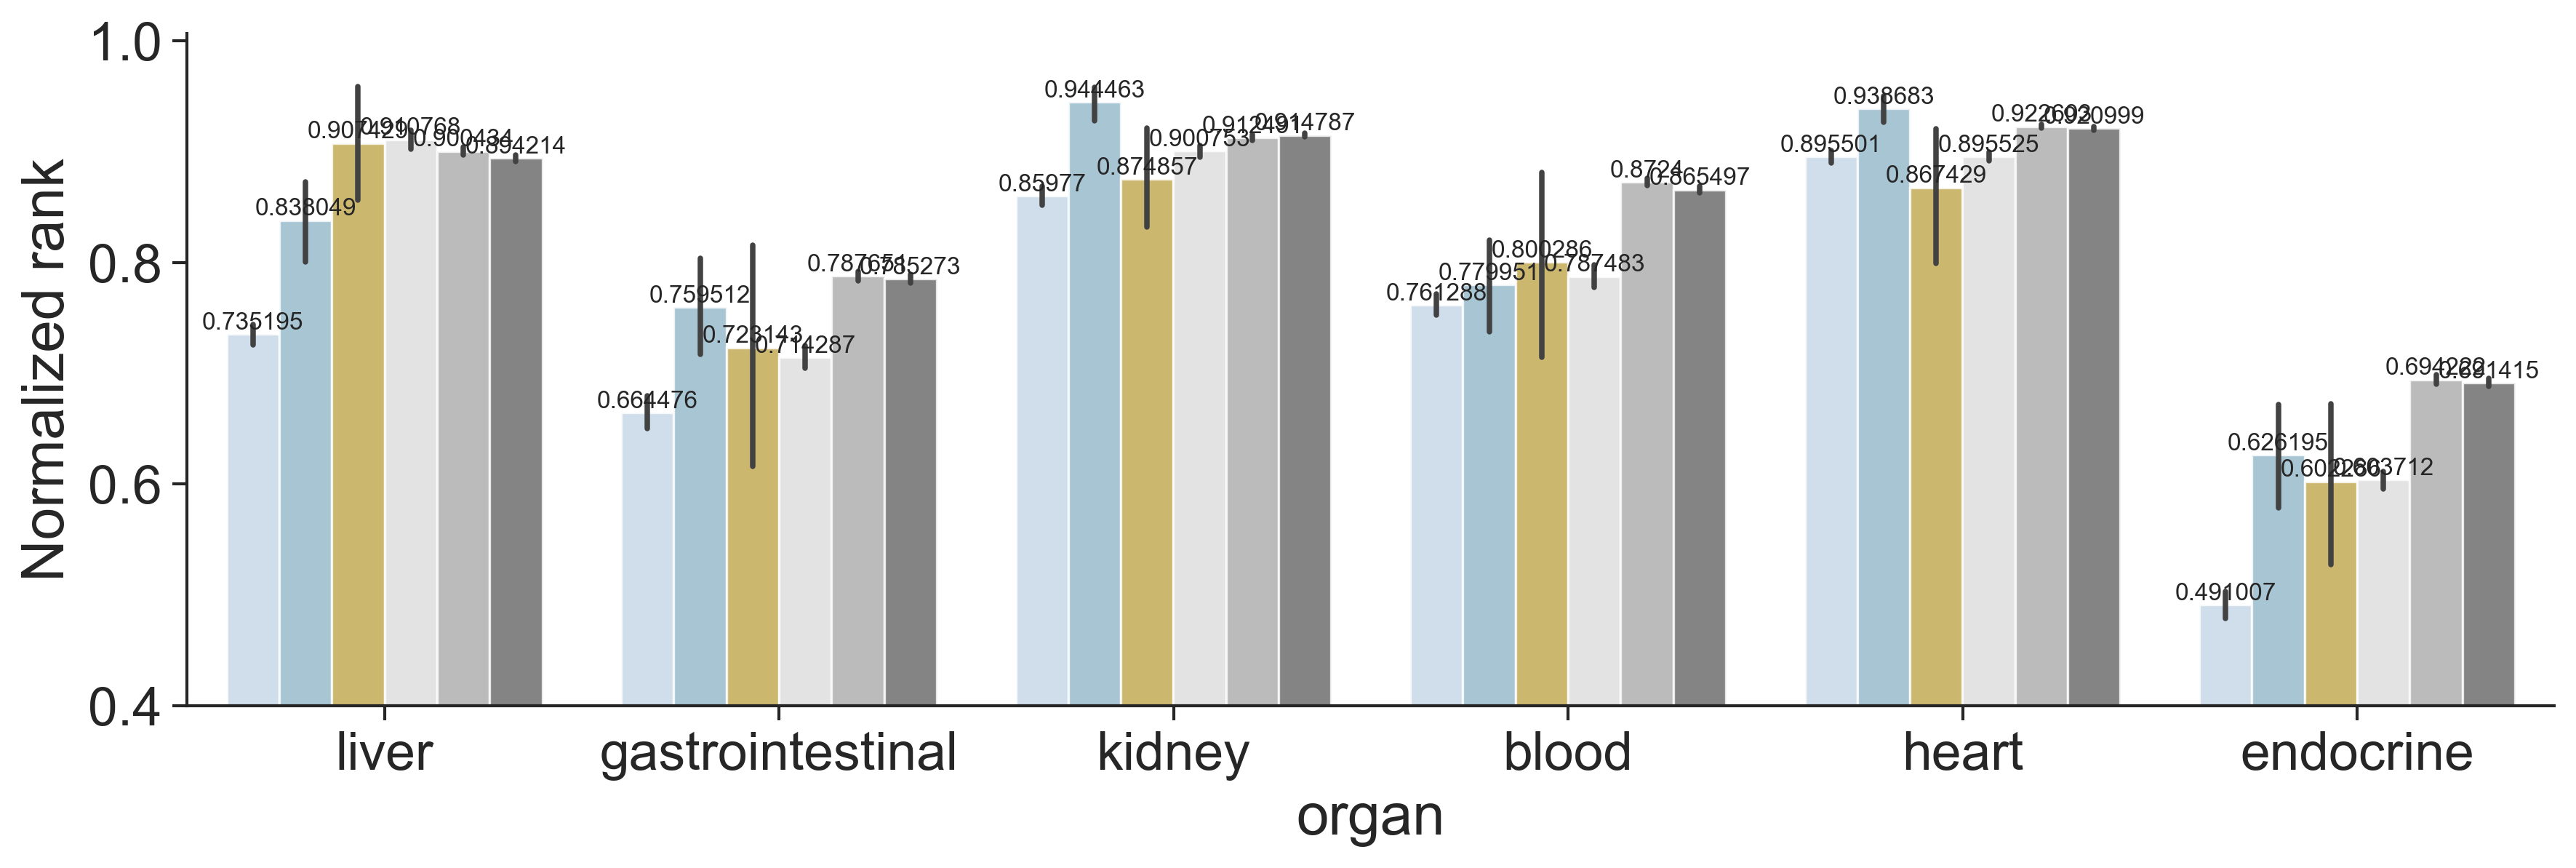

In [51]:
plot_data_all = (pd.melt(
    plot_data_highest_5_mean,
    id_vars=["drug_pair", "group"], 
    # value_vars=["others/general", "endocrine", "heart", "blood", "kidney", "gastrointestinal", "liver"],
    value_vars=["liver", "gastrointestinal", "kidney", "blood", "heart", "endocrine", ],
    var_name="organ",
).explode(column="value").reset_index(drop=True))
plot_data_all = plot_data_all[
    ~(
        (plot_data_all["drug_pair"].isin([k for k, v in parpi_drug_pairs_phase.items() if v == "phase 1"])) & \
        (plot_data_all["group"] == "PARPi combinations (clinically investigated or approved)")
    )
]

from matplotlib import font_manager as fm
arial_path = "../arial.ttf"
fm.fontManager.addfont(arial_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(14, 4), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
custom_palette = [
    '#BFD7EA',  # Faded cornflower blue 1
    '#8ABAD3',  # Faded cornflower blue 2
    '#D4AF37',  # Elegant gold
    '#DDDDDD',  # Light gray
    '#AAAAAA',  # Medium gray
    '#666666'   # Dark gray
]
ax = sns.barplot(
    data = plot_data_all.round(3), 
    x="organ", y="value", hue="group", 
    hue_order=[
        "FDA-approved drug combinations", 
        "FDA-approved drug combinations (at least one cancer drug)",
        "PARPi combinations (clinically investigated or approved)", 
        "PARPi combinations (with any other cancer drug)", 
        "clinically investigated drug combinations (cancer indications)",
        "clinically investigated drug combinations (at least one cancer drug)", 
    ],
    palette=custom_palette, 
    alpha=.8
)
for container in ax.containers:
    ax.bar_label(container, fontsize=8)
sns.despine()
plt.legend(bbox_to_anchor=(1, 0.5), loc="upper right", frameon=False) 
plt.legend().set_visible(False)
plt.ylim(0.4)
plt.ylabel("Normalized rank")
# plt.xlabel("Organ")
plt.show()

## Organ-stratified safety for PARPi combinations

Aggregate all pairs for each PARPi, across organ

In [499]:
test_exploded, _ = add_organs_column(
    test_long, None, 
    organ_class_mapping, organs_of_interest, organ_counts, 
    sample_name_col_name="(parpi; pan cancer drug)", num_least_organ=5
)

In [ ]:
test_exploded = test_exploded.drop(columns=["cancer drug id"]).groupby(by=["parpi", "cancer drug", "organ"]).agg(list)
test_exploded["organ_highest_5_mean"] = test_exploded["value"].apply(lambda lst: np.mean(np.partition(lst, len(lst)-5)[-5:]))
test_exploded["organ_highest_3_mean"] = test_exploded["value"].apply(lambda lst: np.mean(np.partition(lst, len(lst)-3)[-3:]))
test_exploded = test_exploded.reset_index()
test_exploded[["highest_5_ddi_class", "highest_5_values"]] = pd.DataFrame(test_exploded[["ddi_class", "value"]].apply(
    lambda row: [np.array(row[0])[np.argpartition(row[1], len(row[1])-5)[-5:]], np.partition(row[1], len(row[1])-5)[-5:]], axis=1
).tolist())
test_exploded[["highest_3_ddi_class", "highest_3_values"]] = pd.DataFrame(test_exploded[["ddi_class", "value"]].apply(
    lambda row: [np.array(row[0])[np.argpartition(row[1], len(row[1])-3)[-3:]], np.partition(row[1], len(row[1])-3)[-3:]], axis=1
).tolist())
test_exploded

parpi      cancer drug             organ  \
0        olaparib      abemaciclib             blood   
1        olaparib      abemaciclib         endocrine   
2        olaparib      abemaciclib  gastrointestinal   
3        olaparib      abemaciclib             heart   
4        olaparib      abemaciclib            kidney   
...           ...              ...               ...   
6043  talazoparib  zoledronic acid  gastrointestinal   
6044  talazoparib  zoledronic acid             heart   
6045  talazoparib  zoledronic acid            kidney   
6046  talazoparib  zoledronic acid             liver   
6047  talazoparib  zoledronic acid    others/general   

                                              ddi_class  \
0     [anticoagulant, decrease, anticoagulant, incre...   
1     [Change in thyroid function, increase, hypergl...   
2     [bleeding, gastrointestinal bleeding, increase...   
3     [QTc prolongation, decrease, QTc prolongation,...   
4     [antihypertension, decrease, antihypertension,...   
...                                                 ...   
6043  [bleeding, gastrointestinal bleeding, increase...   
6044  [QTc prolongation, decrease, QTc prolongation,...   
6045  [antihypertension, decrease, antihypertension,...   
6046  [excretion rate, decrease | serum level, incre...   
6047  [CNS depression, hypotonia, increase, CNS depr...   

                                                  value  organ_highest_5_mean  \
0     [0.6267498731613159, 0.5893012285232544, 0.628...              0.842384   
1     [0.6247789263725281, 0.5713529586791992, 0.824...              0.621427   
2     [0.8721370100975037, 0.5071950554847717, 0.960...              0.816922   
3     [0.3908228278160095, 0.2305779904127121, 0.530...              0.920939   
4     [0.7862287759780884, 0.13964325189590454, 0.74...              0.941995   
...                                                 ...                   ...   
6043  [0.29111620783805847, 0.22559534013271332, 0.0...              0.390681   
6044  [0.2034325897693634, 0.741380512714386, 0.6732...              0.820633   
6045  [0.3618561923503876, 0.33726903796195984, 0.21...              0.819356   
6046  [0.1922285407781601, 0.1624995768070221, 0.495...              0.319573   
6047  [0.4326370656490326, 0.5947607755661011, 0.999...              0.986479   

      organ_highest_3_mean  organ_highest_2_mean  \
0                 0.888815              0.936056   
1                 0.673643              0.724788   
2                 0.940724              0.975018   
3                 0.948148              0.977575   
4                 0.983288              0.995643   
...                    ...                   ...   
6043              0.460747              0.524227   
6044              0.861887              0.865023   
6045              0.887083              0.919375   
6046              0.414378              0.470819   
6047              0.998204              0.999672   

                                    highest_5_ddi_class  \
0     [hemorrhage, increase, bleeding, hemorrhage, i...   
1     [Change in thyroid function, increase, hypergl...   
2     [urinary retention, reduced gastrointestinal m...   
3     [orthostatic hypotension, syncope, increase, c...   
4     [hypertension, hyponatremia, water intoxicatio...   
...                                                 ...   
6043  [reduced gastrointestinal motility, increase, ...   
6044  [QTc prolongation, hypotension, increase, hypo...   
6045  [renal failure, hypotension, hyperkalemia, inc...   
6046  [excretion rate, increase | serum level, decre...   
6047  [photosensitizing, increase, effectiveness as ...   

                                       highest_5_values  \
0     [0.7642287015914917, 0.7812435030937195, 0.999...   
1     [0.6247789263725281, 0.5713529586791992, 0.464...   
2     [0.6223920583724976, 0.6400459408760071, 0.989...   
3     [0.8721061944961548, 0.9965722560882568, 0.889...   
4     [0.8247973322868347, 0

In [501]:
valid_drugs_list = []
for drug_id in all_other_drugs_list:
    drug_ind = drug_id_to_ind[drug_id]
    temp = organs_csv.iloc[db_polypharmacy[(db_polypharmacy['drug_index_1'] == drug_ind)]["label_indexed"]]
    temp["count"] = 1
    if set(["blood", "liver", "kidney"]) - set(temp.groupby(by=["ddi_class", "organ"]).agg(sum).reset_index().query("count >= 5")["organ"].str.split(", ").explode().tolist()) == set():
        valid_drugs_list.append(drug_id)

/tmp/ipykernel_21393/941089983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["count"] = 1
/tmp/ipykernel_21393/941089983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["count"] = 1
/tmp/ipykernel_21393/941089983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [ ]:
np.random.seed(42)
ctrl_drug_ids = np.random.choice(valid_drugs_list, size=50, replace=False)
ctrl_df = pd.DataFrame({
    "node_id": ctrl_drug_ids,
    "node_name": [drug_id_to_name[drug_id] for drug_id in ctrl_drug_ids],
})
pan_cancer_ctrl_df, pan_cancer_ctrl_df_filtered = get_parpi_cancer_drug_ddi_scores(ctrl_df, "pan", pan_cancer_drugs)

ctrl_long = pd.melt(
    pan_cancer_ctrl_df_filtered.reset_index(), 
    id_vars=pan_cancer_ctrl_df_filtered.index.name,
    value_vars=pan_cancer_ctrl_df_filtered.columns, 
    var_name="ddi_class"
)
ctrl_long[["parpi", "cancer drug"]] = ctrl_long["(parpi; pan cancer drug)"].str.split("; ", expand=True)
ctrl_long["cancer drug id"] = ctrl_long["cancer drug"].apply(lambda x: drug_name_to_id[x])
ctrl_long = ctrl_long.drop(columns=["(parpi; pan cancer drug)"])[["parpi", "cancer drug", "cancer drug id", "ddi_class", "value"]]

ctrl_exploded, _ = add_organs_column(
    ctrl_long, None, 
    organ_class_mapping, organs_of_interest, organ_counts, 
    sample_name_col_name="(parpi; pan cancer drug)", num_least_organ=5
)

ctrl_exploded = ctrl_exploded.drop(columns=["cancer drug id"]).groupby(by=["parpi", "cancer drug", "organ"]).agg(list)
ctrl_exploded["organ_highest_5_mean"] = ctrl_exploded["value"].apply(lambda lst: np.mean(np.partition(lst, len(lst)-5)[-5:]))
ctrl_exploded["organ_highest_3_mean"] = ctrl_exploded["value"].apply(lambda lst: np.mean(np.partition(lst, len(lst)-3)[-3:]))
ctrl_exploded["organ_highest_2_mean"] = ctrl_exploded["value"].apply(lambda lst: np.mean(np.partition(lst, len(lst)-2)[-2:]))
ctrl_exploded = ctrl_exploded.reset_index()
ctrl_exploded[["highest_5_ddi_class", "highest_5_values"]] = pd.DataFrame(ctrl_exploded[["ddi_class", "value"]].apply(
    lambda row: [np.array(row[0])[np.argpartition(row[1], len(row[1])-5)[-5:]], np.partition(row[1], len(row[1])-5)[-5:]], axis=1
).tolist(), index=ctrl_exploded.index)
ctrl_exploded[["highest_3_ddi_class", "highest_3_values"]] = pd.DataFrame(ctrl_exploded[["ddi_class", "value"]].apply(
    lambda row: [np.array(row[0])[np.argpartition(row[1], len(row[1])-3)[-3:]], np.partition(row[1], len(row[1])-3)[-3:]], axis=1
).tolist(), index=ctrl_exploded.index)
ctrl_exploded

parpi      cancer drug             organ  \
0       acetaminophen      abemaciclib             blood   
1       acetaminophen      abemaciclib         endocrine   
2       acetaminophen      abemaciclib  gastrointestinal   
3       acetaminophen      abemaciclib             heart   
4       acetaminophen      abemaciclib            kidney   
...               ...              ...               ...   
100795     zonisamide  zoledronic acid  gastrointestinal   
100796     zonisamide  zoledronic acid             heart   
100797     zonisamide  zoledronic acid            kidney   
100798     zonisamide  zoledronic acid             liver   
100799     zonisamide  zoledronic acid    others/general   

                                                ddi_class  \
0       [anticoagulant, decrease, anticoagulant, incre...   
1       [Change in thyroid function, increase, hypergl...   
2       [bleeding, gastrointestinal bleeding, increase...   
3       [QTc prolongation, decrease, QTc prolongation,...   
4       [antihypertension, decrease, antihypertension,...   
...                                                   ...   
100795  [bleeding, gastrointestinal bleeding, increase...   
100796  [QTc prolongation, decrease, QTc prolongation,...   
100797  [antihypertension, decrease, antihypertension,...   
100798  [excretion rate, decrease | serum level, incre...   
100799  [CNS depression, hypotonia, increase, CNS depr...   

                                                    value  \
0       [0.7869628071784973, 0.7194963097572327, 0.774...   
1       [0.5182154178619385, 0.5348148941993713, 0.550...   
2       [0.9045484066009521, 0.5811236500740051, 0.486...   
3       [0.7303885817527771, 0.739124059677124, 0.5712...   
4       [0.6074947118759155, 0.683414101600647, 0.8164...   
...                                                   ...   
100795  [0.6836979985237122, 0.9506798386573792, 0.705...   
100796  [0.8797466158866882, 0.7512295842170715, 0.975...   
100797  [0.9626978635787964, 0.861066997051239, 0.7375...   
100798  [0.915489137172699, 0.6131924986839294, 0.7197...   
100799  [0.9480866193771362, 0.6850380897521973, 0.242...   

        organ_highest_5_mean  organ_highest_3_mean  organ_highest_2_mean  \
0                   0.940284              0.971624              0.987545   
1                   0.562885              0.577775              0.599255   
2                   0.913845              0.952042              0.975789   
3                   0.853374              0.866338              0.874768   
4                   0.862906              0.904894              0.931054   
...                      ...                   ...                   ...   
100795              0.956137              0.973462              0.984852   
100796              0.989473              0.996516              0.998236   
100797              0.988485              0.997190              0.999248   
100798              0.827722              0.906624              0.925065   
100799              0.992623              0.994707              0.996038   

                                      highest_5_ddi_class  \
0       [thrombosis, increase, neutropenia, increase, ...   
1       [Change in thyroid function, increase, hypergl...   
2       [gastrointestinal ulceration, increase, gastro...   
3       [QTc prolongation, torsade de pointes, cardiot...   
4       [excretion rate, decrease | serum level, incre...   
...                                                   ...   
100795  [gastrointestinal bleeding, peptic ulcer, incr...   
100796  [fluid retention, vasopressor, increase, hyper...   
100797  [renal failure, hypertension, increase, fluid ...   
100798  [liver enzyme elevations, increase, liver dama...   
100799  [bronchoconstrictory, increase, neuromuscular ...   

                                         highest_5_values  \
0       [0.8819978833198547, 0.9975747466087341, 0.939...   
1       [0.5182154178619385, 0.5348148941993713, 0.550...   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


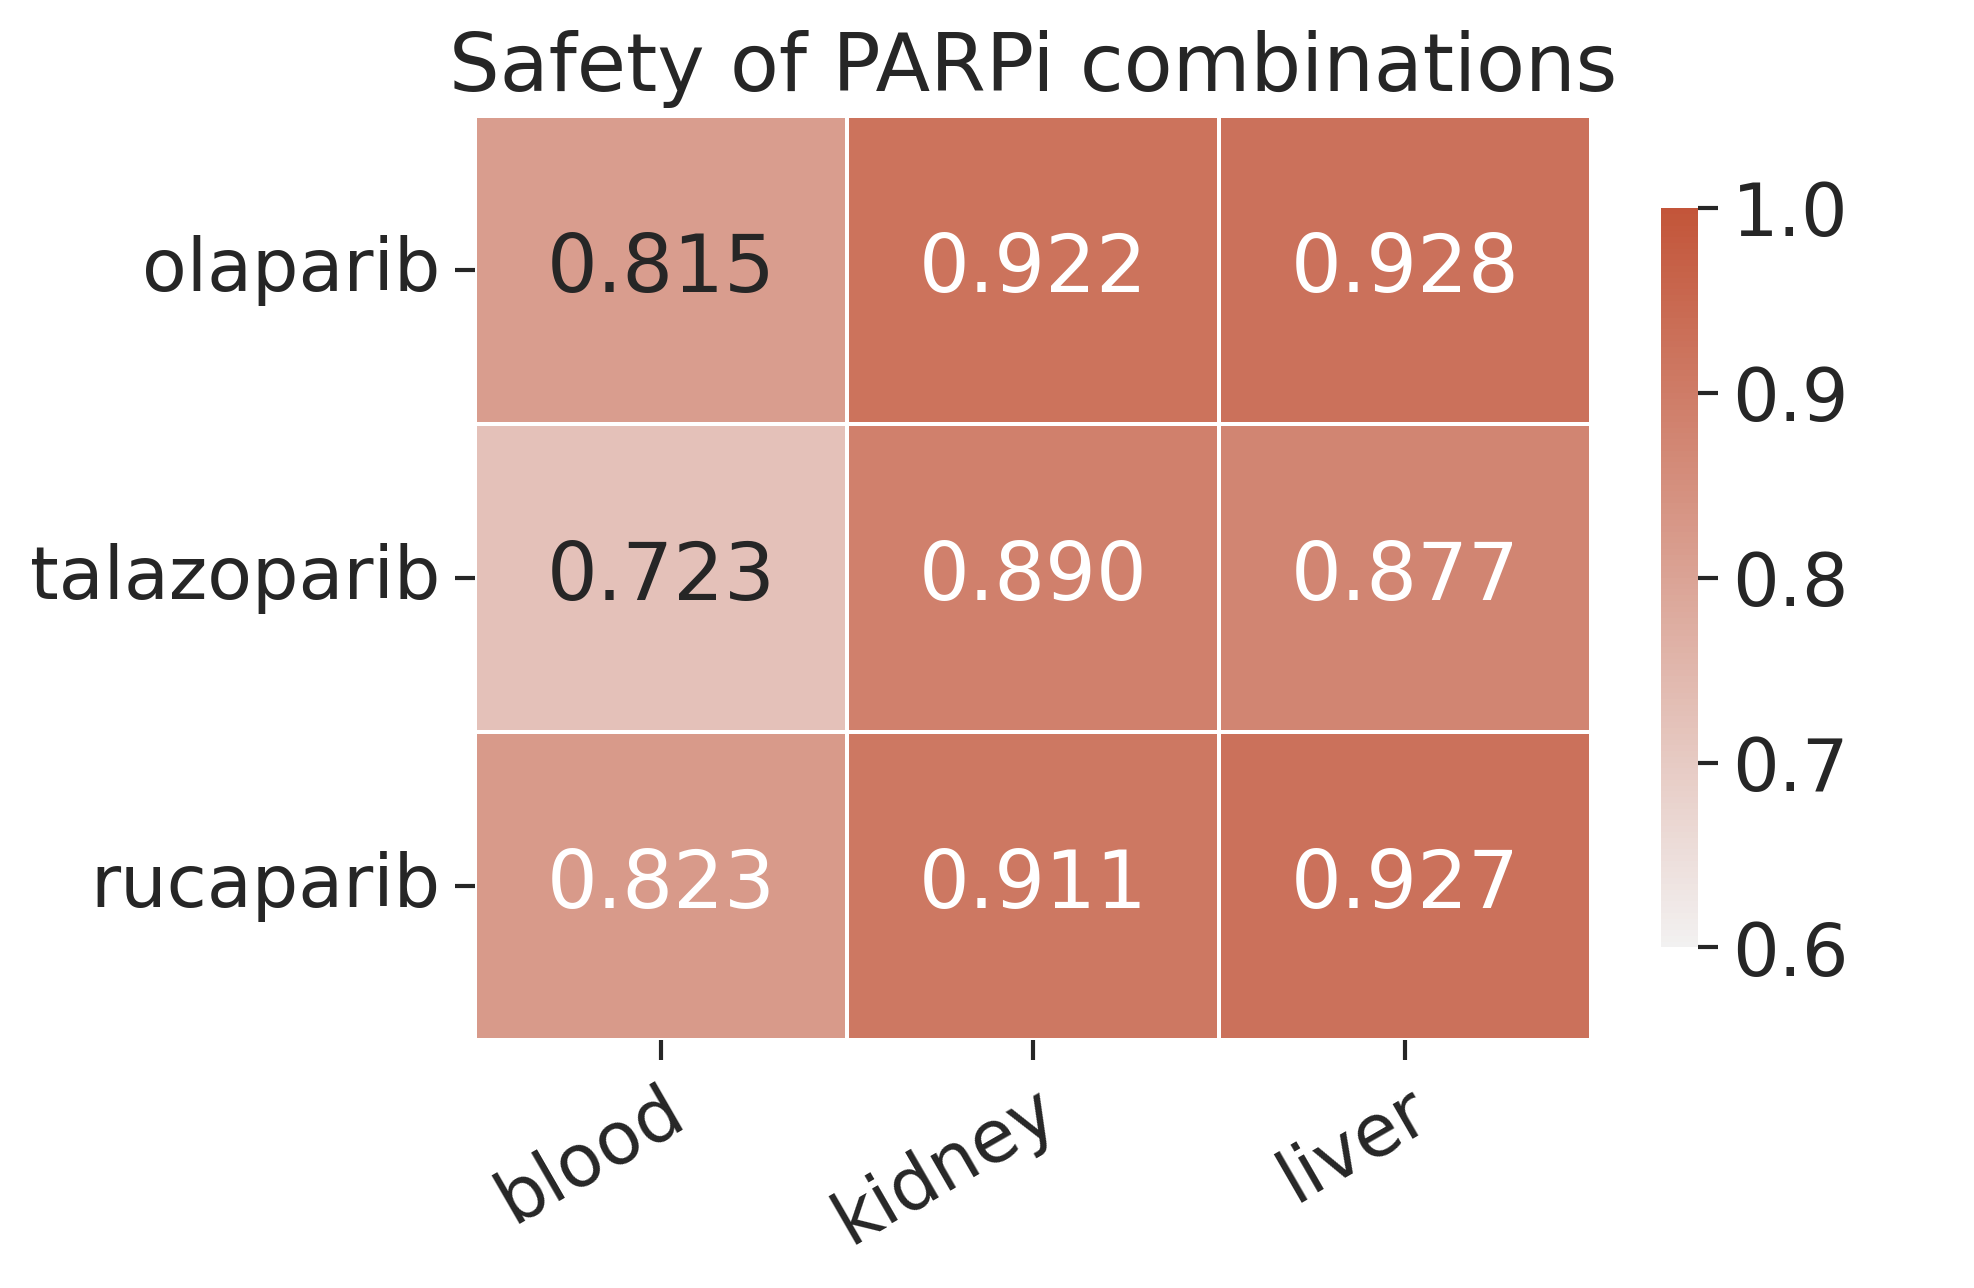

In [ ]:
temp = test_exploded[["parpi", "organ", "organ_highest_5_mean"]].groupby(by=["parpi", "organ"]).agg(np.mean).reset_index()
temp = pd.pivot_table(temp, values="organ_highest_5_mean", index="parpi", columns="organ").loc[
    [
        "olaparib", 
        "talazoparib", 
        "rucaparib", 
    ],
    [
        "blood", 
        "kidney", 
        "liver",
    ]
]

plt.figure(figsize=(6, 4), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    temp, annot=True, 
    fmt=".3f",
    cmap=cmap, 
    linewidths=.5,
    cbar_kws={"shrink": .8}, 
    center=.6, 
    vmax=1.0, vmin=0.6,
)

plt.title('Safety of PARPi combinations')
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=30, rotation_mode="anchor", ha="right")
plt.legend(bbox_to_anchor=(1.35, 1.0), loc='upper right', frameon=False)
plt.show()

## Visualizing safety for clinically-investigating PARPi combinations

Plot the clinically investigating combinations with their ranks among all pairs

In [25]:
papi_cancer_drug_for_stripplot = []
ddi_scores_for_stripplot = []
ddi_classes_for_stripplot = []
ddi_organs_for_stripplot = []
assert max(sum(specific_organs_mapping.values(), start=[])) == 150

for parpi_name, cancer_drug_list in studied_parpi_combos.items():
    if parpi_name == "olaparib": cancer_drug_list += ["paclitaxel"]  # positive control
    for cancer_drug_name in cancer_drug_list:
        if cancer_drug_name in drug_metadata["node_name"].dropna().str.lower().values:
            print(parpi_name, cancer_drug_name)
            parpi_index = drug_name_to_ind[parpi_name]
            cancer_drug_index = drug_name_to_ind[cancer_drug_name]
            ddi_filtered = normalized_rank_drugbank[:, parpi_index, cancer_drug_index][valid_ddi_class_indices]

            # specific_organs_mapping
            for organ, organ_ddi_index_lst in specific_organs_mapping.items():
                ddi_scores_for_stripplot.extend(ddi_filtered[organ_ddi_index_lst])
                ddi_classes_for_stripplot.extend(ddi_classes[valid_ddi_class_indices][organ_ddi_index_lst])
                ddi_organs_for_stripplot.extend([organ] * len(organ_ddi_index_lst))
                papi_cancer_drug_for_stripplot.extend([f"{parpi_name}; {cancer_drug_name}"] * len(organ_ddi_index_lst))

olaparib temozolomide
olaparib cediranib
olaparib alpelisib
olaparib capivasertib
olaparib selumetinib
olaparib ceralasertib
olaparib prexasertib
olaparib mk-1775
olaparib abiraterone
olaparib paclitaxel
veliparib paclitaxel
veliparib carboplatin
veliparib cisplatin
veliparib gemcitabine
veliparib temozolomide
veliparib irinotecan
veliparib fluorouracil
veliparib lapatinib
rucaparib temozolomide
talazoparib enzalutamide
niraparib abiraterone


In [26]:
studied_pairs_df_filtered = pd.DataFrame.from_dict({
    "(parpi; pan cancer drug)": papi_cancer_drug_for_stripplot,
    "ddi_class": ddi_classes_for_stripplot,
    "value": ddi_scores_for_stripplot,
    "organ": ddi_organs_for_stripplot,
})
studied_pairs_df_filtered

(parpi; pan cancer drug)  \
0      olaparib; temozolomide   
1      olaparib; temozolomide   
2      olaparib; temozolomide   
3      olaparib; temozolomide   
4      olaparib; temozolomide   
...                       ...   
3754   niraparib; abiraterone   
3755   niraparib; abiraterone   
3756   niraparib; abiraterone   
3757   niraparib; abiraterone   
3758   niraparib; abiraterone   

                                              ddi_class     value  \
0                   CNS depression, hypotonia, increase  0.770616   
1                              CNS depression, increase  0.468345   
2                                  absorption, decrease  0.422404   
3     absorption, decrease | serum level, decrease |...  0.643751   
4     absorption, increase | serum level, increase |...  0.828964   
...                                                 ...       ...   
3754                                excretion, increase  0.726810   
3755                             liver damage, increase  0.294671   
3756                  liver enzyme elevations, increase  0.455113   
3757                               metabolism, decrease  0.061869   
3758                               metabolism, increase  0.172315   

               organ  
0     others/general  
1     others/general  
2     others/general  
3     others/general  
4     others/general  
...              ...  
3754           liver  
3755           liver  
3756           liver  
3757           liver  
3758           liver  

[3759 rows x 4 columns]

In [27]:
studied_pairs_df_filtered["drug_pair_with_phase"] = (
    studied_pairs_df_filtered["(parpi; pan cancer drug)"] + "\n(" + \
    studied_pairs_df_filtered["(parpi; pan cancer drug)"].apply(lambda x: parpi_drug_pairs_phase[x]) + \
    ")"
)

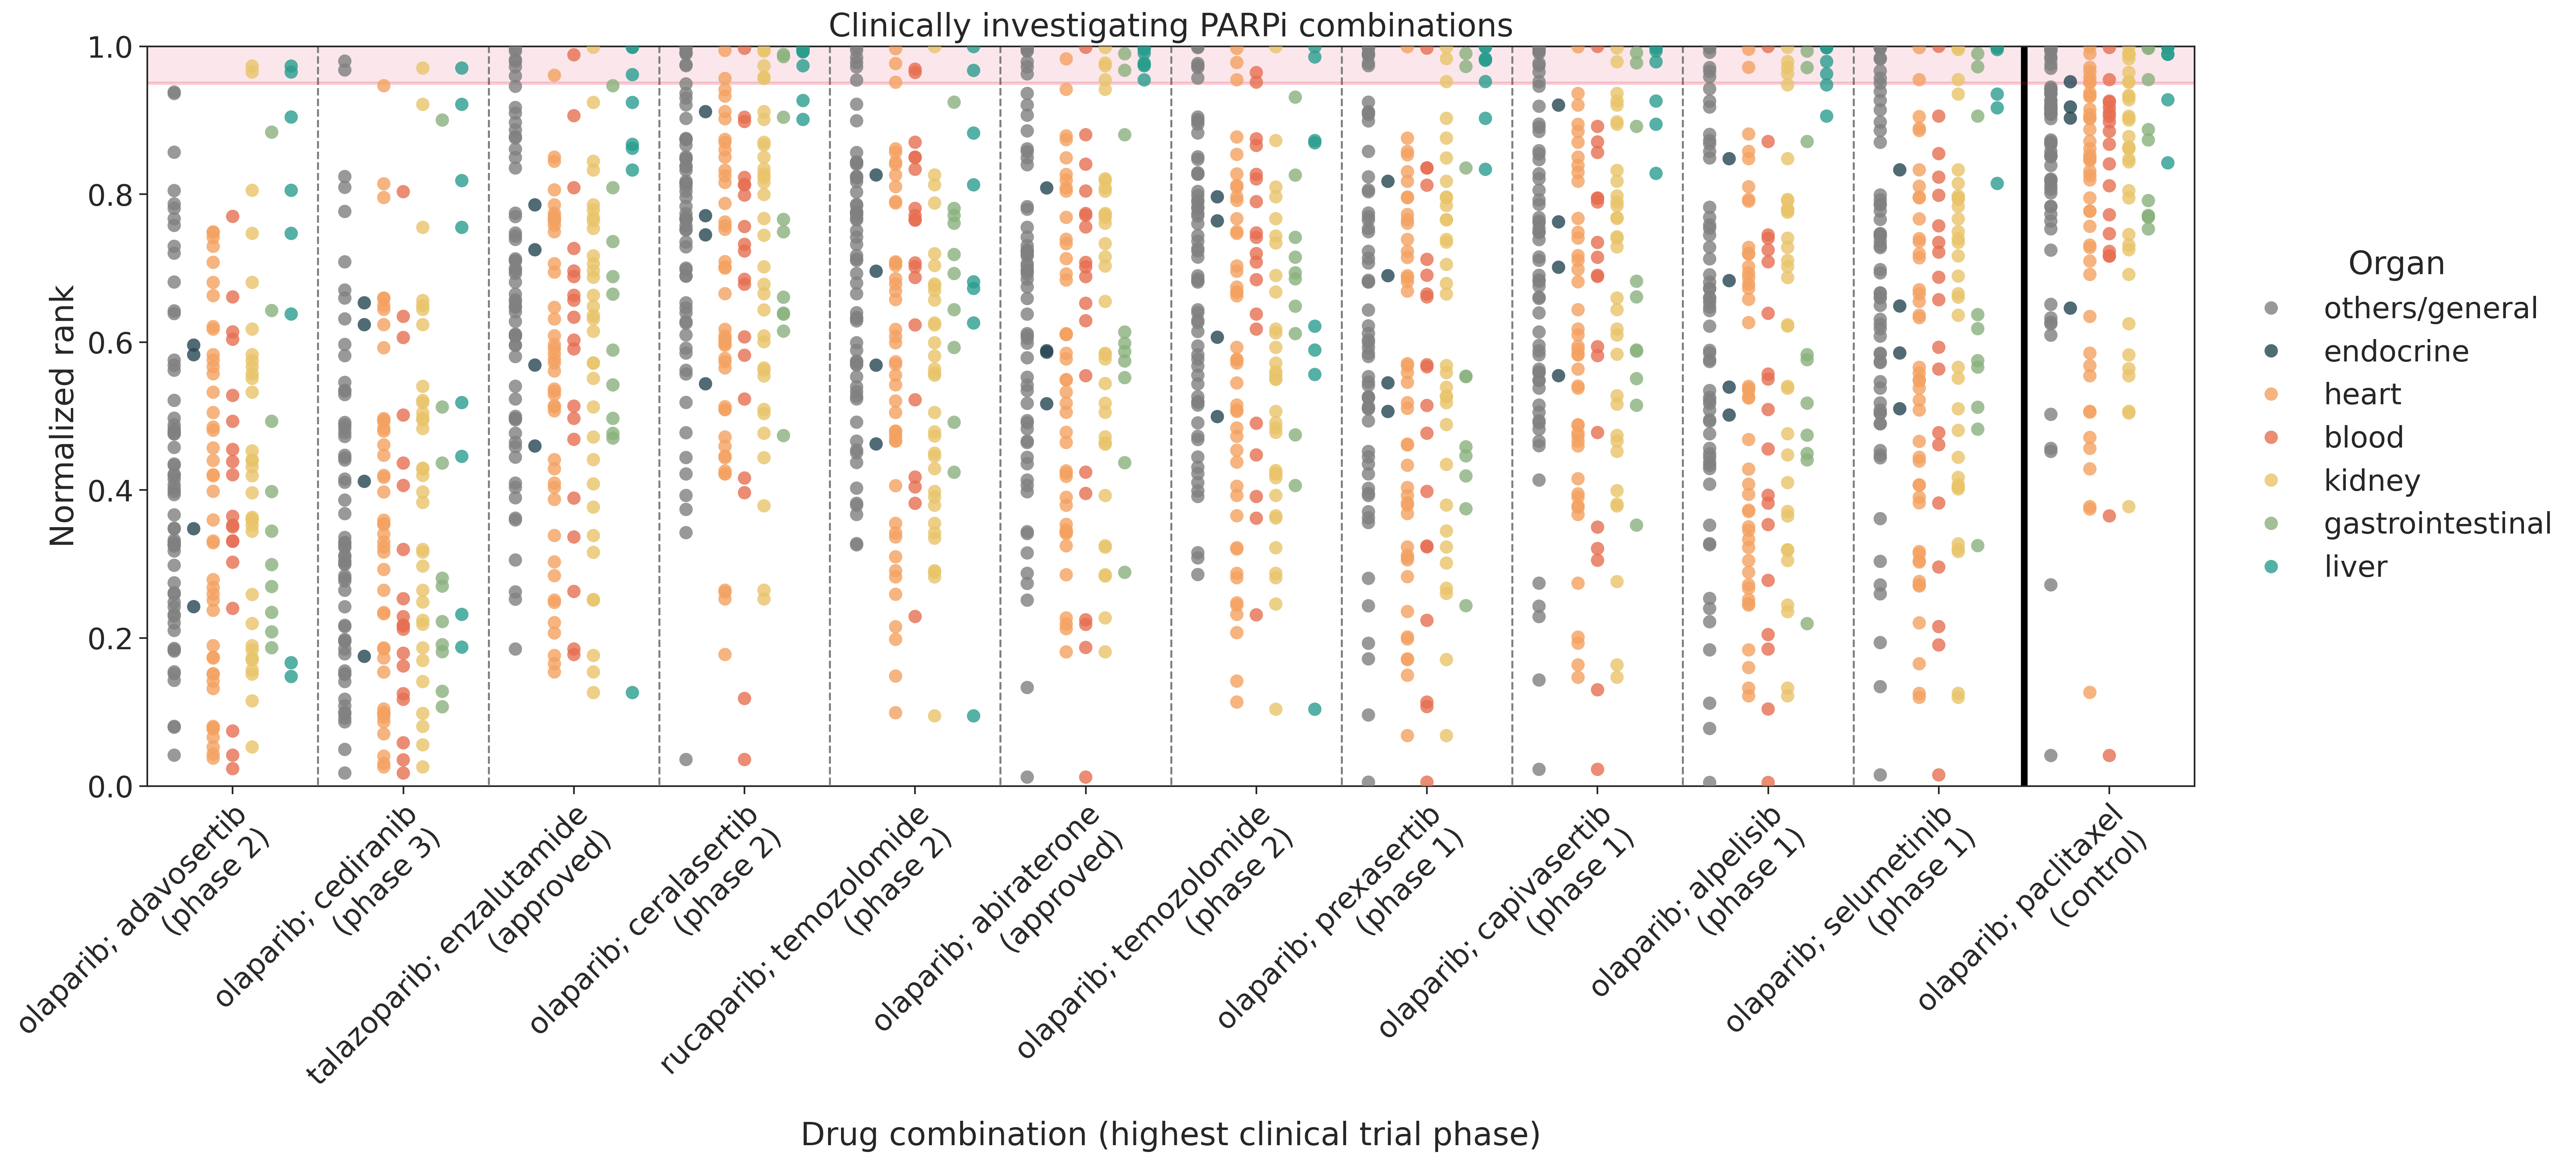

In [ ]:
# plot_title = "PARPis and Studied Cancer Drugs: Unsafe Drug Pairs\n(High predicted associations between drug combination and adverse events)"
plot_title = "Clinically investigating PARPi combinations"
sample_name_col_name = "drug_pair_with_phase"
print_ddi_class_or_organ_num = "organ_num"
custom_palette = {
    "others/general": "grey", 
    "blood": "#e76f51",  # lightpink
    "heart": "#f4a261",  # marron
    "kidney": "#e9c46a",  # darkmagenta
    "gastrointestinal": "#8ab17d",  # mediumseagreen
    "liver": "#2a9d8f",  # cornflowerblue, steelblue
    "endocrine": "#264653",
}

studied_pairs_df_filtered["(parpi; pan cancer drug)"] = studied_pairs_df_filtered["(parpi; pan cancer drug)"].str.replace("mk-1775", "adavosertib")
studied_pairs_df_filtered["drug_pair_with_phase"] = studied_pairs_df_filtered["drug_pair_with_phase"].str.replace("mk-1775", "adavosertib")
plot_data = studied_pairs_df_filtered.copy()
plot_data = plot_data[~plot_data["(parpi; pan cancer drug)"].str.contains("veliparib")]
plot_data = plot_data[~plot_data["(parpi; pan cancer drug)"].str.contains("niraparib")]

# Initialize the figure
plt.figure(figsize=(22, 8), dpi=300)
plt.rcParams["font.family"] = "Arial"
sns.set(style="ticks", context="paper", font_scale=2)

# Show each observation with a scatterplot
order = plot_data.groupby(sample_name_col_name).agg(list)["value"].apply(
    lambda x: np.mean(np.partition(x, len(x)-5)[-5:])
).sort_values().index.values
sns.stripplot(
    data=plot_data, y="value", x=sample_name_col_name, hue="organ", 
    palette=custom_palette, dodge=1.0, jitter=False, alpha=.8, order=order, s=8
)

# Put dashed horizontal lines to separate the drug combinations
x = 0.5
while x < 11.5:
    if x != 10.5:
        plt.axvline(x=x, ymin=-0.5, ymax=3.5, ls="--", color="grey")
    else:
        plt.axvline(x=x, ymin=-0.5, ymax=3.5, ls="-", lw=4, color="black")
    x += 1

threshold_to_count_ddi = 0.95
plt.ylim([0, 1])
plt.xlim([-0.5, 11.5])
plt.axhline(y=threshold_to_count_ddi, c="crimson", lw=2, alpha=0.2)
plt.axhspan(threshold_to_count_ddi, 1.0, color="crimson", alpha=0.1, lw=0)
plt.ylabel("Normalized rank")
plt.xlabel("Drug combination (highest clinical trial phase)")
plt.title(plot_title)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', frameon=False, title="Organ")

# plt.savefig("./figs/fig4_clinically_investigating_parpi_cancer_drug_pairs_stripplot.svg", format="svg", dpi=300)
plt.show()